In [16]:
import os
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.keras.backend import clear_session
from tensorflow_probability import distributions as tfd
import utilities.functions as funs

# Set the random generators for reproducibility.
os.environ['PYTHONHASHSEED']=str(12345)
random.seed(12345)
rng = np.random.default_rng(12345)
tf.random.set_seed(12345)

# Configure a new global `tensorflow` session:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [17]:
wine = pd.read_csv('../Data/wine.csv')

In [18]:
y = wine.quality.astype('float64')
X = wine.drop('quality', axis=1).astype({'type':'str'})

In [19]:
X_train, X_test, X_valid, y_train, y_test, y_valid = funs.transform(X, y)

Regression

In [20]:
kl_weight = 1 / X_train.shape[0]

### 1. Deterministic – *standard* – Neural Network Regressor



In [21]:
# Sequential coding of standard neural network.
model = keras.models.Sequential([
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mse')
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

In [22]:
funs.metrics_printer(metrics, machine='regressor')

TEST METRICS
MSE 	 0.53


In [23]:
# funs.metrics_plotter(history, ['loss'], loss="mse")

In [24]:
# Functional coding of standard neural network.
inputs = tf.keras.Input(shape=(X_train.shape[1], ))
layers = keras.layers.Dense(4, activation='sigmoid')(inputs)
layers = keras.layers.Dense(4, activation='sigmoid')(layers)
estimate = keras.layers.Dense(1)(layers)

outputs = keras.models.Model(inputs=inputs, outputs=estimate)

outputs.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mse')
history = outputs.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = outputs.evaluate(X_test, y_test, verbose=0)

In [25]:
funs.metrics_printer(metrics, machine='regressor')

TEST METRICS
MSE 	 0.52


## Introducing Porbabilistic Deep Learning

Negative log(Likelihood)

In [26]:
def negloglike(targets, estimated_distribution):        
    return -estimated_distribution.log_prob(targets)

### 2. Probabilistic Neural Network

Probabilistic Neural Network with learnable mean and and constant variance.

<br>

$$ \mathbf{y} \sim \mathrm{N} \left( \mu, \: 1\right)$$

$$ \mu =\mathbb{E} \left[ \mathbf{y} \mid \mathbf{Xw} \right] = \mathbf{Xw}$$

In [27]:
# Sequential coding of standard neural network.
model = keras.models.Sequential([
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['mse'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

In [28]:
funs.metrics_printer(metrics, machine='regressor', p=True)

TEST METRICS
negloglike 	 1.19 
MSE 		 1.46


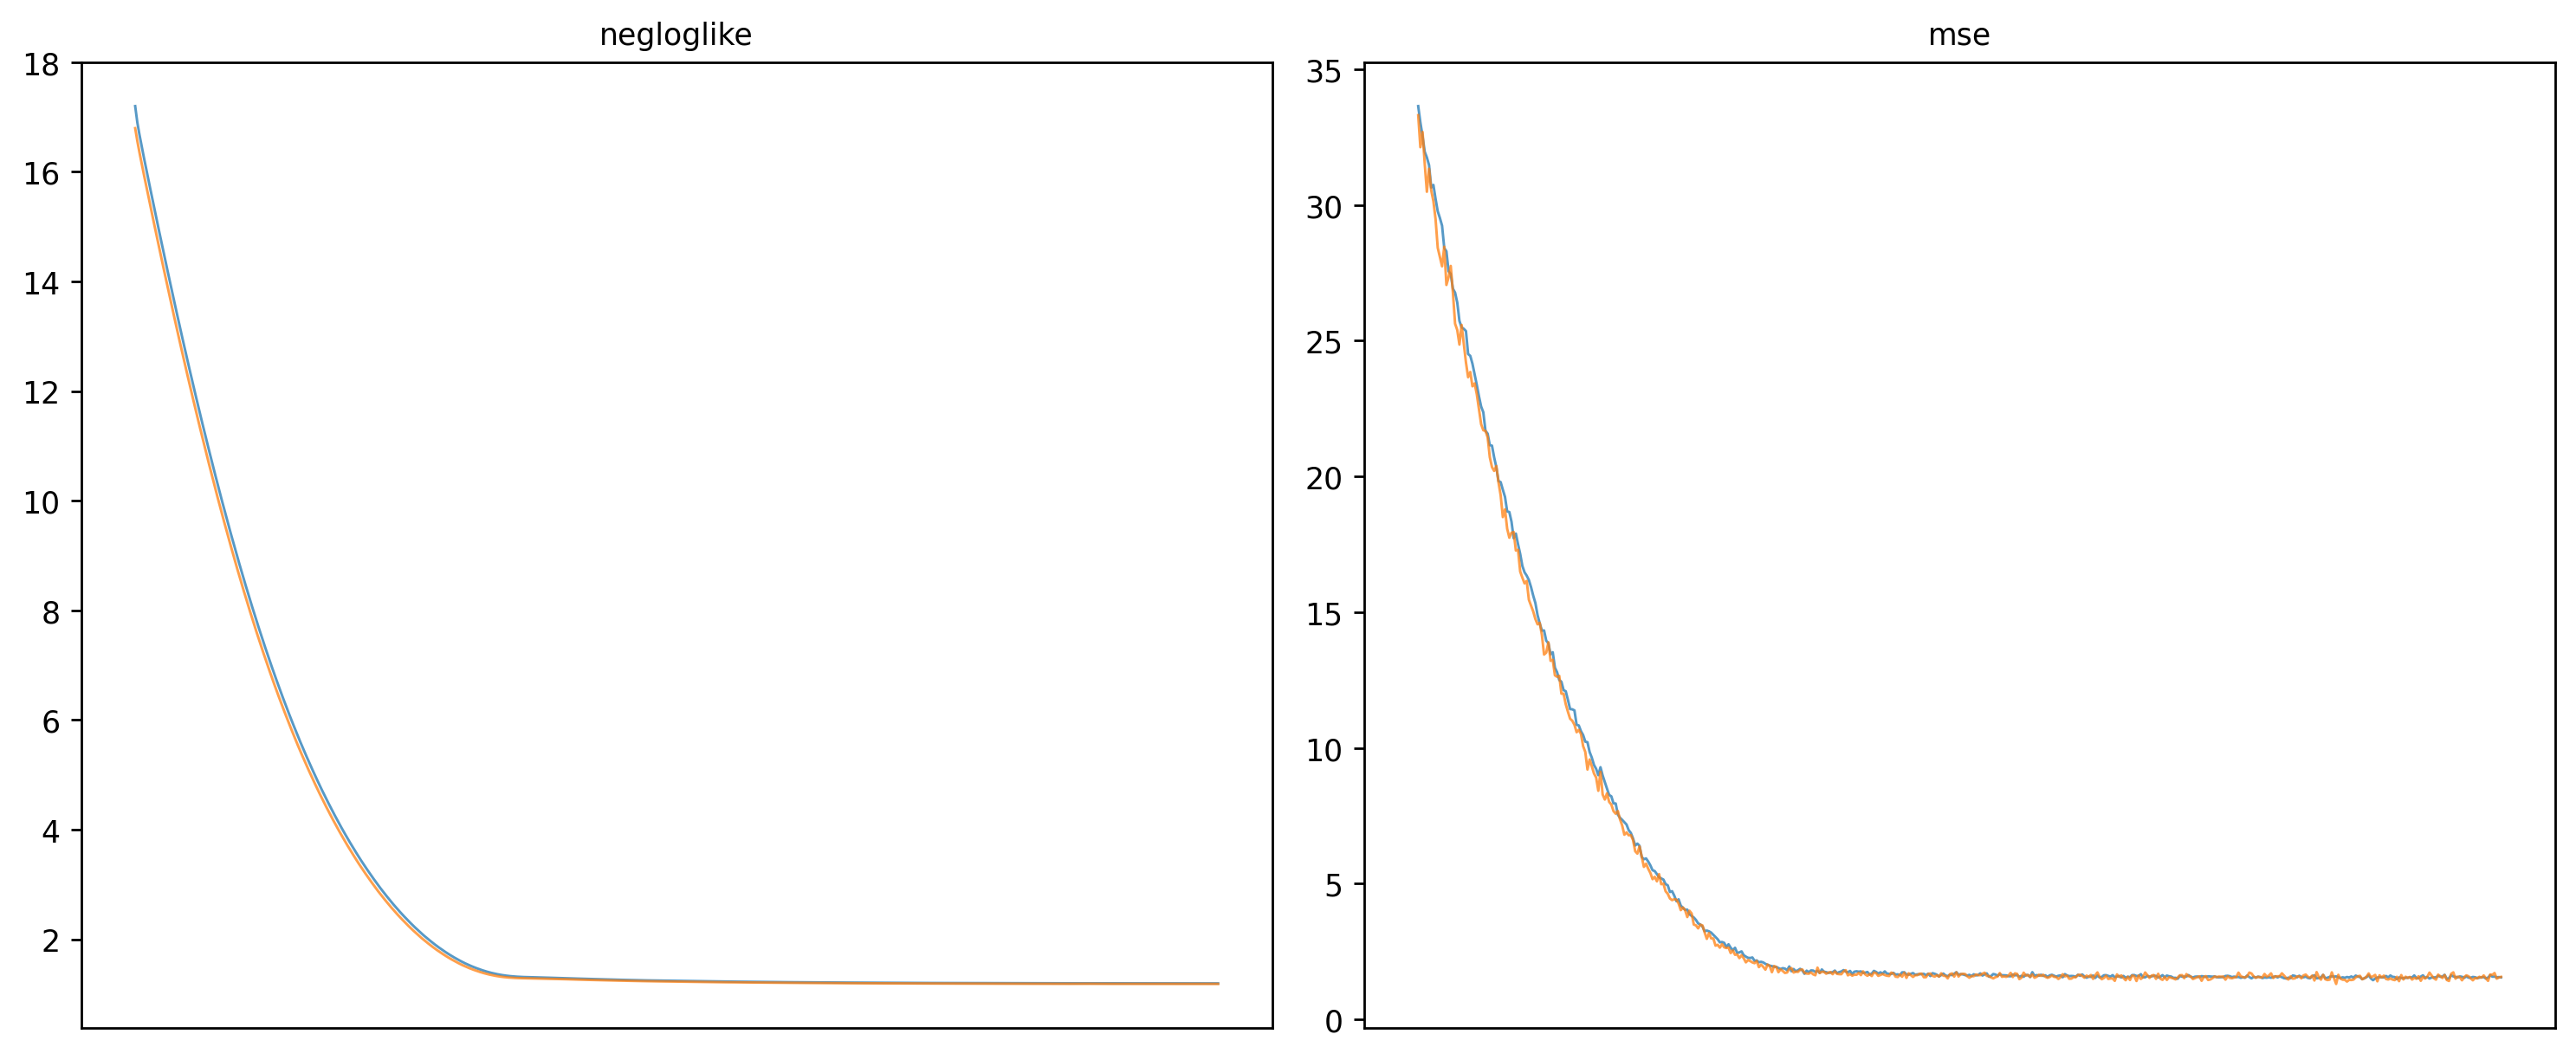

In [29]:
funs.plt_params(250,12,5)
funs.metrics_plotter(history, ['loss','mse'], loss="negloglike")

In [30]:
# Functional coding of probabilistic neural network.
inputs = tf.keras.Input(shape=(X_train.shape[1], ))
layers = keras.layers.Dense(4, activation='sigmoid')(inputs)
layers = keras.layers.Dense(4, activation='sigmoid')(layers)
params = keras.layers.Dense(1)(layers)
distributions =   tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(params)

parameters = keras.models.Model(inputs=inputs, outputs=params)
outputs = keras.models.Model(inputs=inputs, outputs=distributions)

outputs.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['mse'])
history = outputs.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metric = outputs.evaluate(X_test, y_test, verbose=0)

In [31]:
funs.metrics_printer(metrics, machine='regressor', p=True)

TEST METRICS
negloglike 	 1.19 
MSE 		 1.46


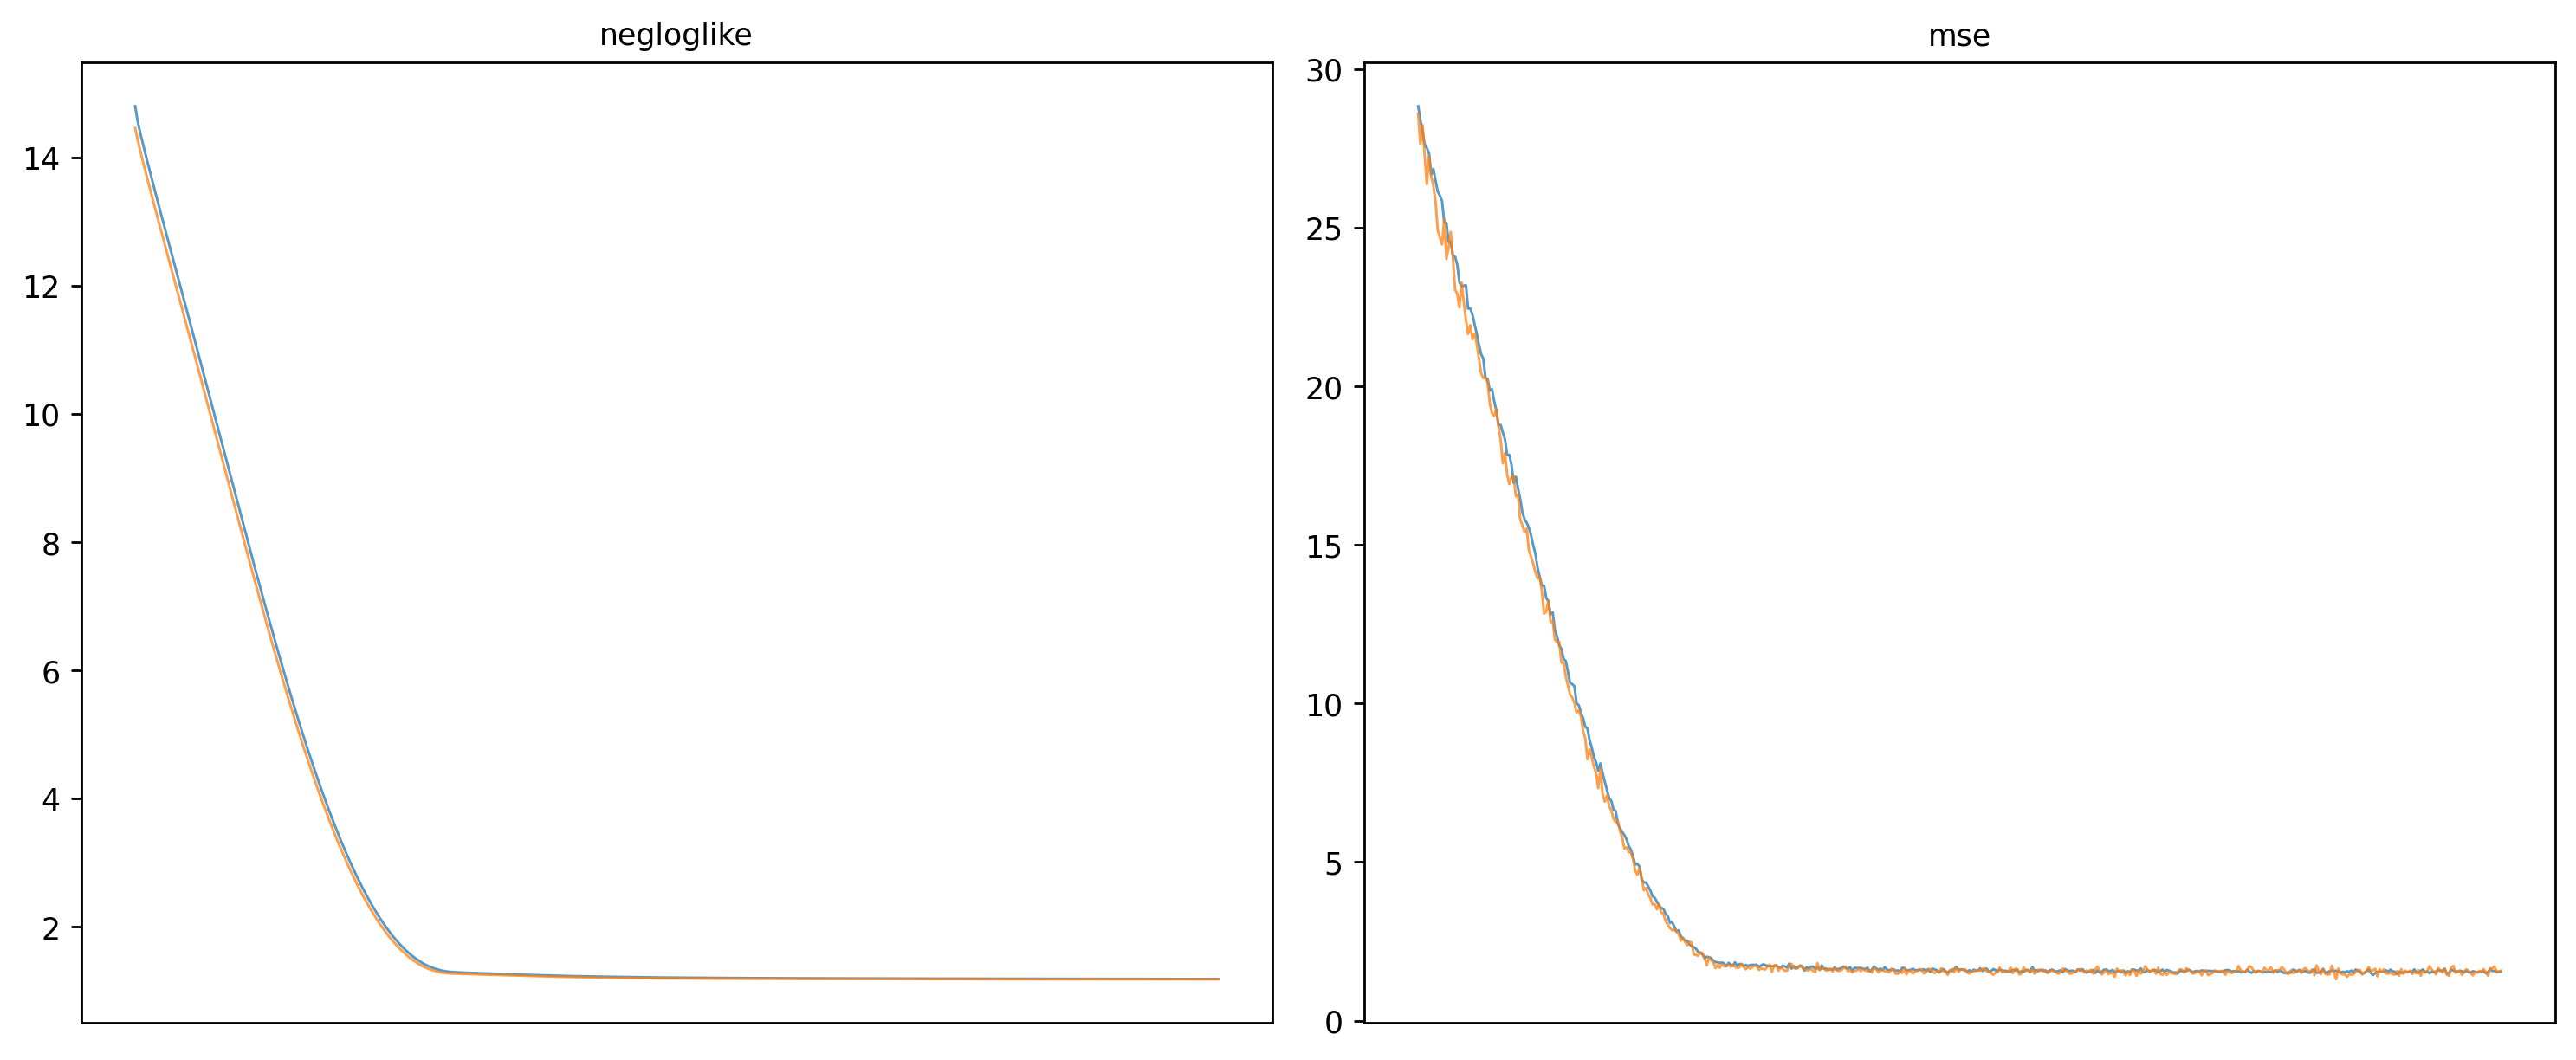

In [32]:
funs.metrics_plotter(history, ['loss','mse'], loss="negloglike")

### 2. Known Unkowns: The *Aleatoric* Uncertainty 

Probabilistic Neural Network with learnable mean and variance.

<br>

$$ \mathbf{y} \sim \mathrm{N} \left( \mu, \: \sigma^{2}_\mathbf{n} \right)$$

$$ \mu =\mathbb{E} \left[ \mathbf{y} \mid \mathbf{Xw} \right] = \mathbf{Xw}$$

In [33]:
# Sequential coding of probabilistic neural network.
model = keras.models.Sequential([
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(4, activation='sigmoid'),
    tf.keras.layers.Dense(2),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
])

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['mse'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

In [34]:
funs.metrics_printer(metrics, machine='regressor', p=True)

TEST METRICS
negloglike 	 1.11 
MSE 		 1.04


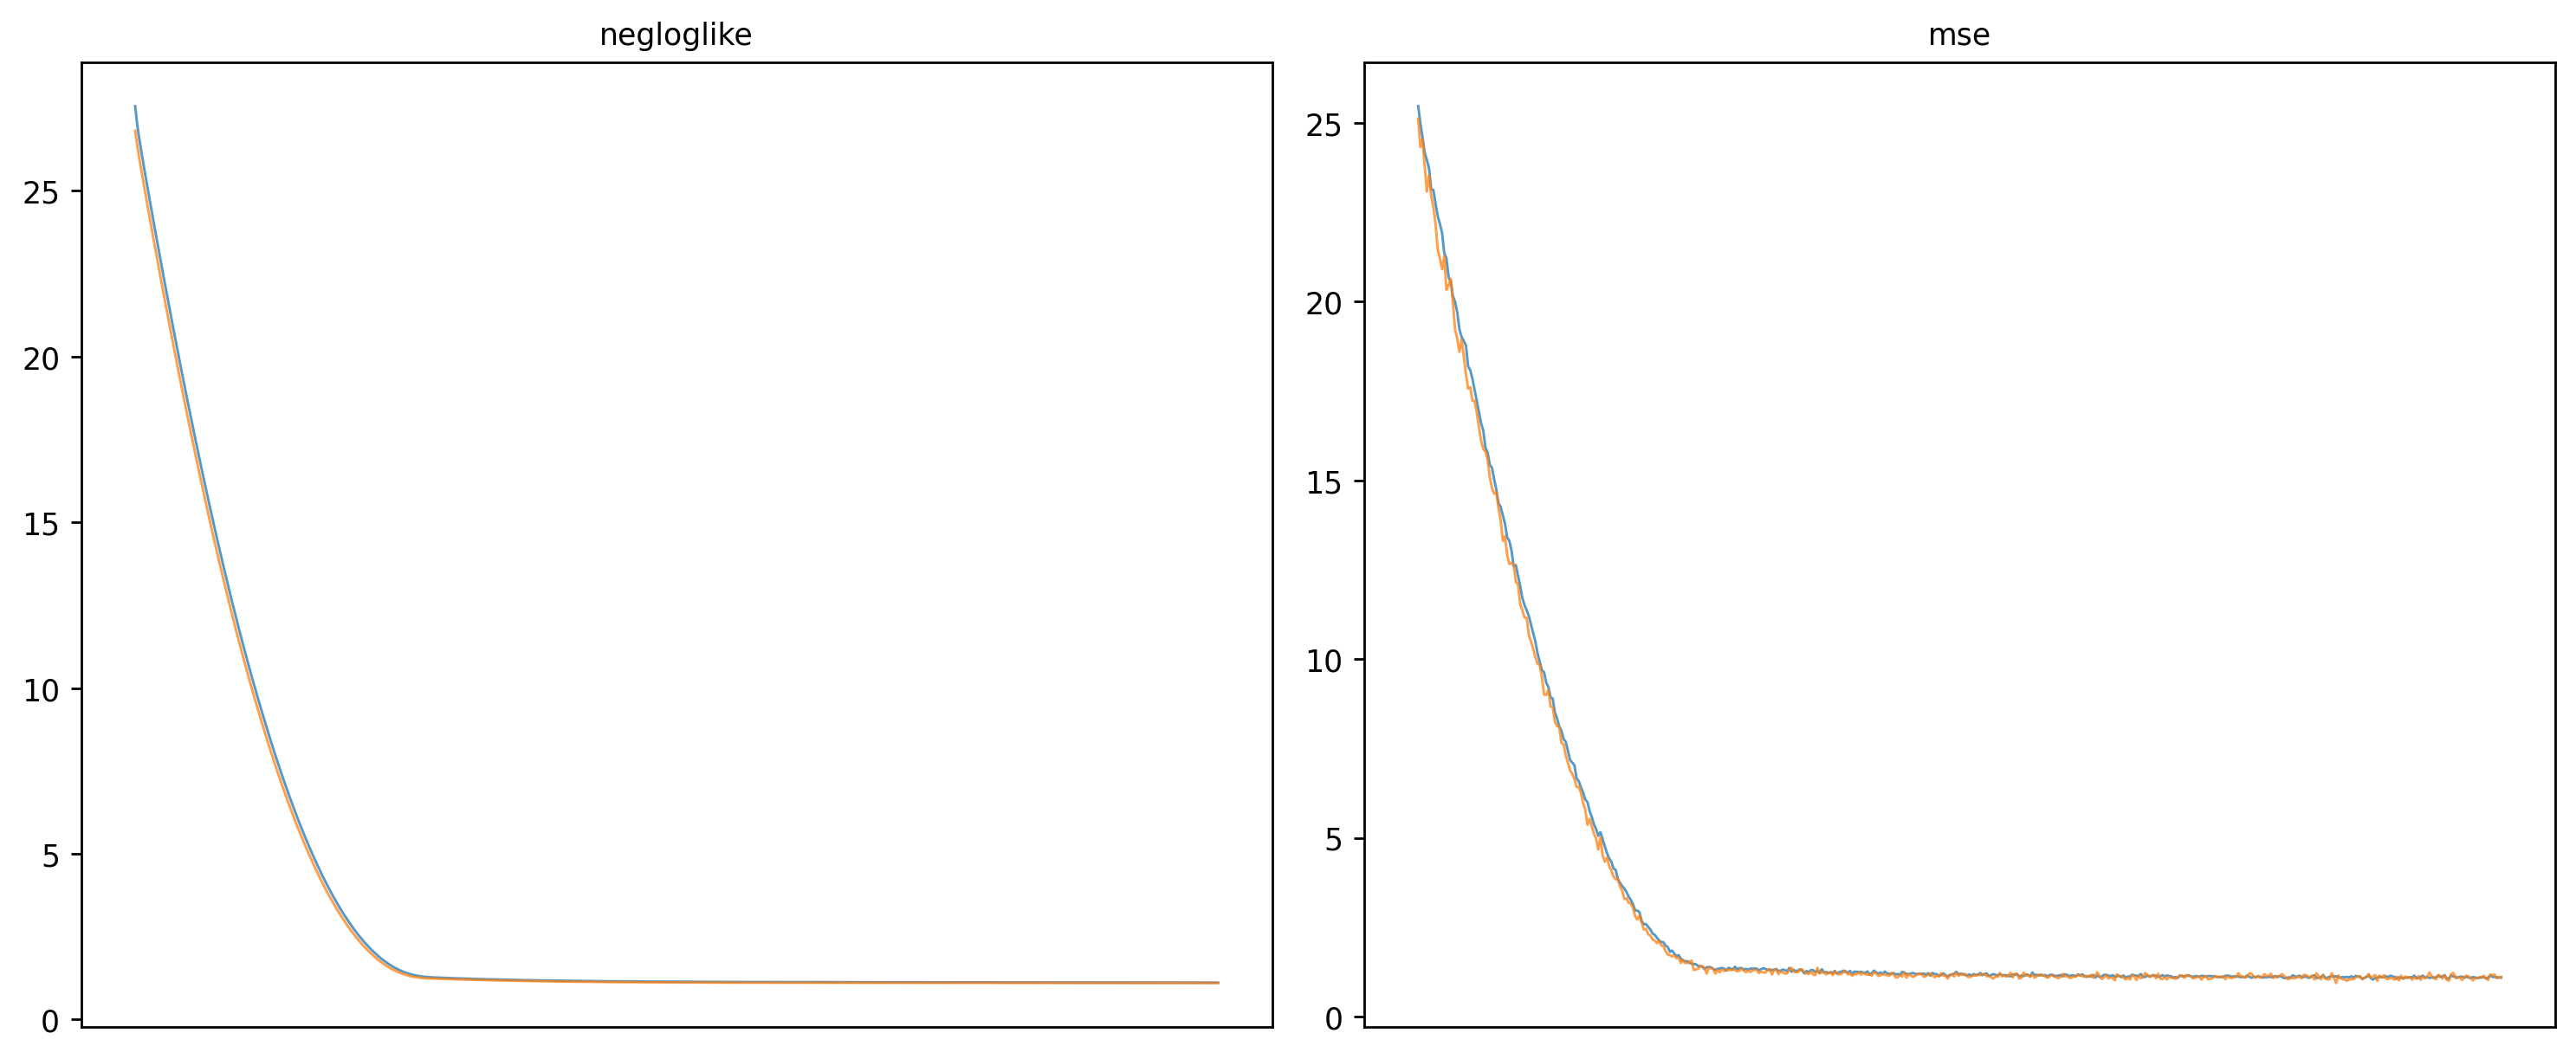

In [35]:
funs.metrics_plotter(history, ['loss','mse'], loss="negloglike")

In [36]:
# Functional coding of probabilistic neural network.
inputs = tf.keras.Input(shape=(X_train.shape[1], ))
layers = keras.layers.Dense(4, activation='sigmoid')(inputs)
layers = keras.layers.Dense(4, activation='sigmoid')(layers)
params = keras.layers.Dense(2)(layers)
distributions =   tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])))(params)

functional = keras.models.Model(inputs=inputs, outputs=distributions)
parameters = keras.models.Model(inputs=inputs, outputs=params)

functional.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['mse'])
history = functional.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metric = functional.evaluate(X_test, y_test, verbose=0)

In [37]:
funs.metrics_printer(metrics, machine='regressor', p=True)

TEST METRICS
negloglike 	 1.11 
MSE 		 1.04


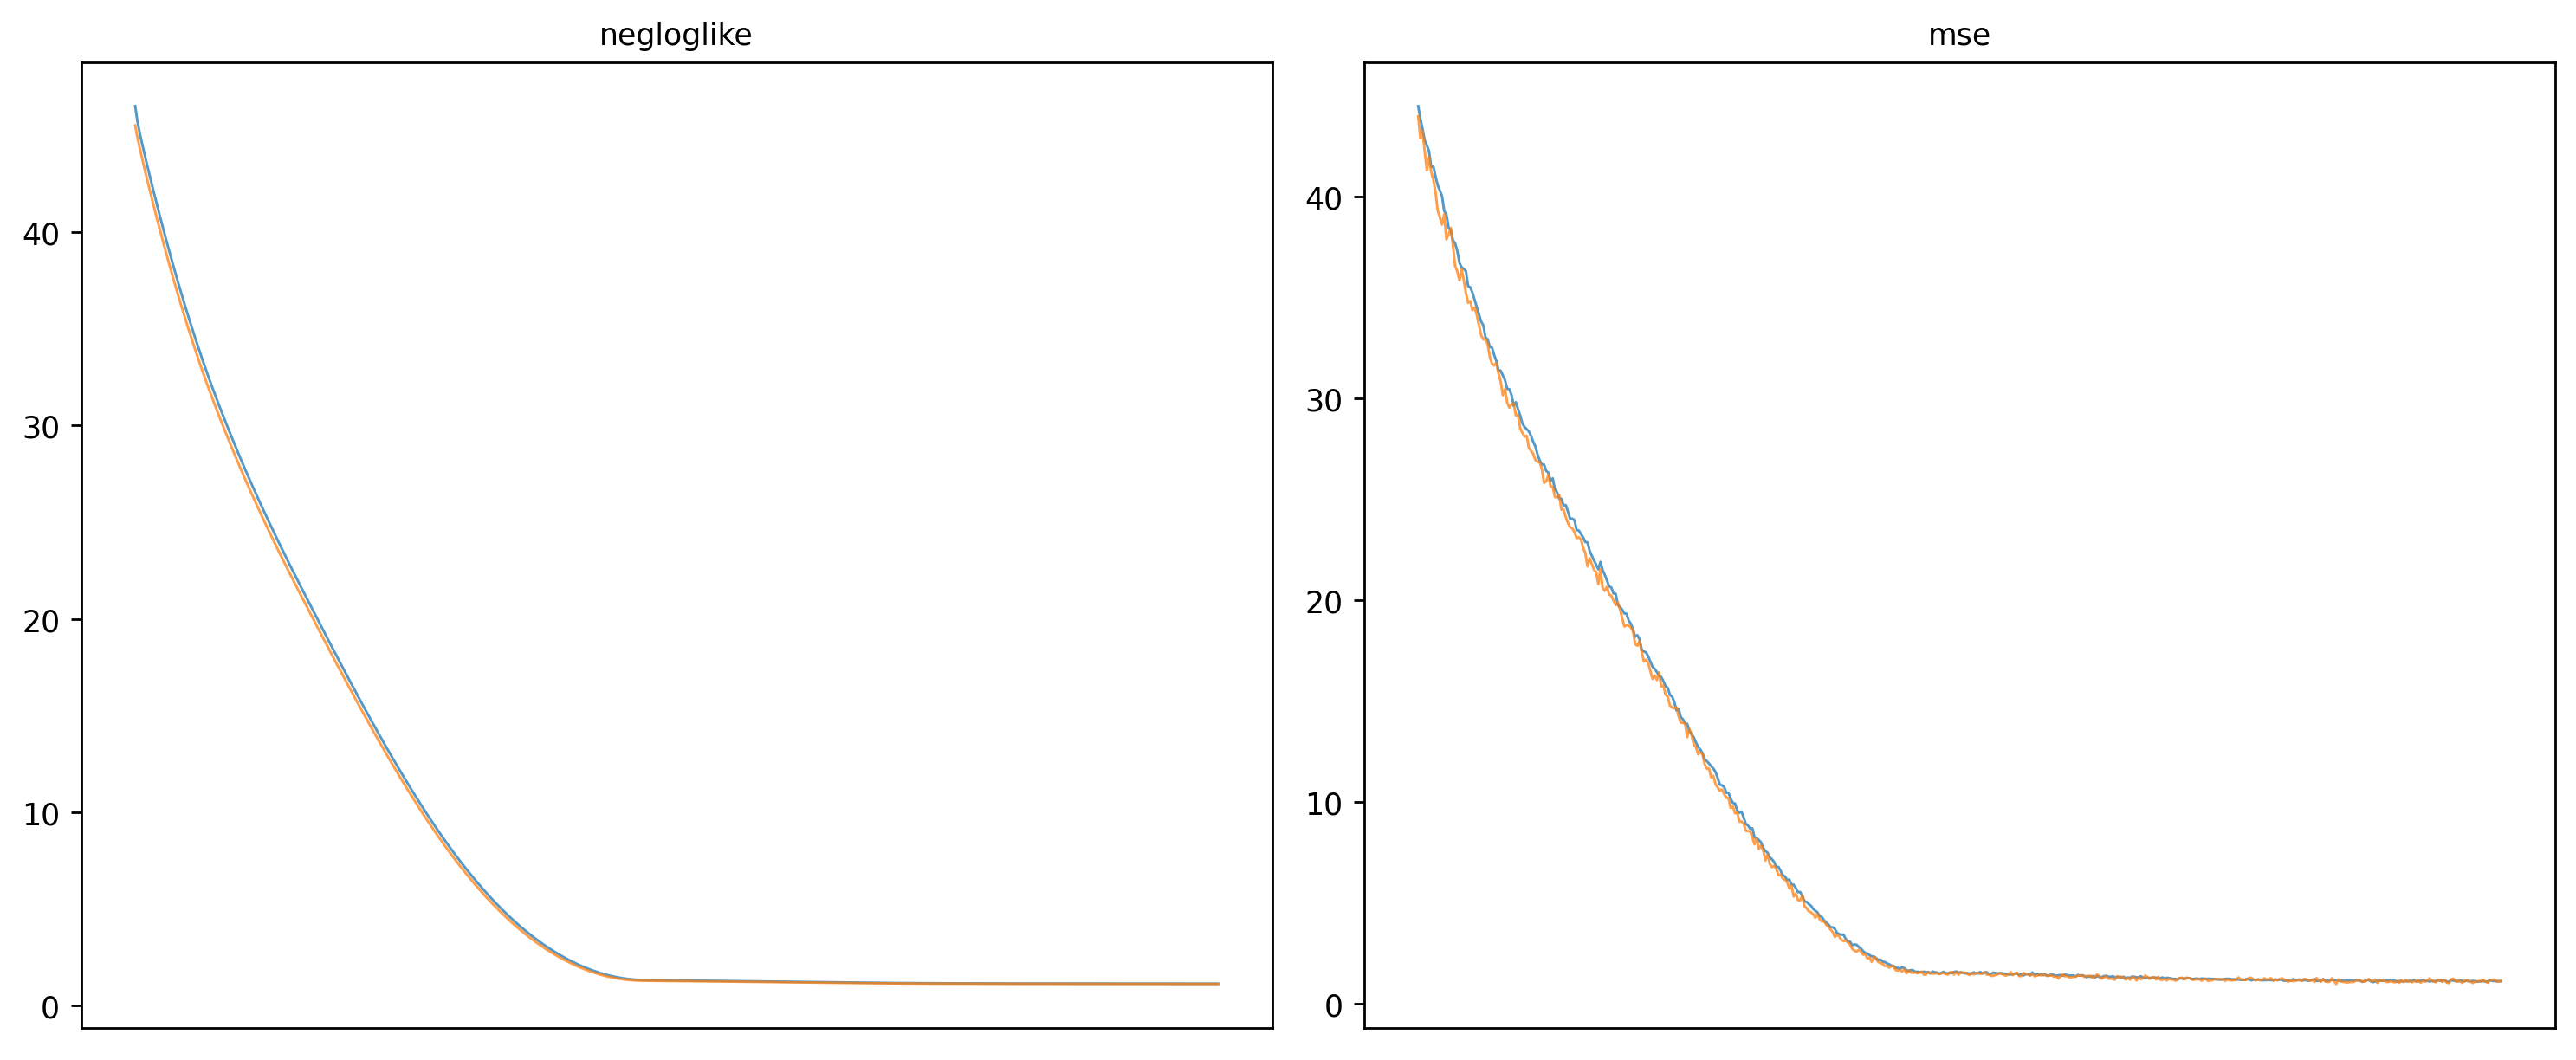

In [38]:
funs.metrics_plotter(history, ['loss','mse'], loss="negloglike")

## Introducing Bayesian Deep Learning

#### Prior Distribution 
$$\pi \left ( \mathbf{W} \right) \sim \mathrm{N} \left( 0, 1 \right)$$

In [39]:
def prior_fn(kernel_size, bias_size, dtype=None):
    # Define the prior weight distribution as Normal(0, 1).
    # The prior is not trainable as the parameters are fixed.
    n = kernel_size + bias_size
    prior = keras.Sequential([
                tfp.layers.DistributionLambda(lambda t: 
                    tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
        ])

    return prior

$$\pi \left ( \mathbf{W} \right) \sim \mathrm{N} \left( \mu, 1 \right)$$

In [40]:
def prior_two(kernel_size, bias_size=0, dtype=None):
    # Define the prior weight distribution as Normal(Xn, 1).
    # The prior is has trainable mean based on the data.
    n = kernel_size + bias_size
    prior = tf.keras.Sequential([
                tfp.layers.VariableLayer(n, dtype=dtype),
                tfp.layers.DistributionLambda(lambda t: 
                    tfd.Independent(tfd.Normal(loc=t, scale=1),reinterpreted_batch_ndims=1)),
    ])

    return prior 

#### Posterior Distribution 

$$P \left( \mathbf{w} \mid \mathcal{D} \right) \sim \mathcal{N}_k \left( \bar{\mu}, \: \bar{\Sigma} \right)$$

$$ \bar{\mu} = \mathbb{E} \left[ \mathbf{X} \right] = \left( \mathbb{E}[X_1], \; \mathbb{E}[X_1], \; ..., \; \mathbb{E}[X_k] \right)$$

In [41]:
def posterior_fn(kernel_size, bias_size, dtype=None):
    # Define variational posterior weight distribution as multivariate Gaussian.
    # Note that the learnable parameters for this distribution are the means, variances, and covariances.
    n = kernel_size + bias_size
    posterior = keras.Sequential([
                    tfp.layers.VariableLayer(
                        tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype), 
                        tfp.layers.MultivariateNormalTriL(n),
    ])
    return posterior

$$P \left( \mathbf{w} \mid \mathcal{D} \right ) \sim \mathrm{N} \left( \mu_{\mathbf{x}},  \sigma^{2}_{\mathbf{x}} \right)$$


$$ \mu_x = \mathbb{E} \left [ \mathbf{\hat{y}} \mid \mathbf{x},\mathbf{w} \right ] = \mathbf{xw}$$

In [42]:
def posterior_two(kernel_size, bias_size=0, dtype=None):
    # Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    posterior =  tf.keras.Sequential([
                    tfp.layers.VariableLayer(2 * n, dtype=dtype),
                    tfp.layers.DistributionLambda(lambda t: 
                        tfd.Independent(tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])), 
                        reinterpreted_batch_ndims=1)),

    ])

    return posterior

### 3. Unknown Unkowns: The *Epistemic Uncertainty*

Bayesian Neural Network

Instead of learning deterministic weights – and bias – , the Bayesian approach learns the weights' distributions - from which it can be sampled to produce an output for a given dataset.

$$P \left( \mathbf{w} \mid \mathcal{D} \right) = \frac{ \mathrm{f} \left( \mathcal{D} \mid \mathbf{w} \right) \pi (\mathbf{w})}{P \left( \mathcal{D} \right)} $$

The weights' prior and posterior distributions need to be defined – the neural network learns the parameters of these distirbutions. If the the parameters are fixed, the prior is not trainable.

$$\pi (\mathbf{w}) \sim \mathrm{N} \left( 0,1 \right)$$

$$P \left( \mathbf{w} \mid \mathcal{D} \right) \sim \mathcal{N}_k \left( \bar{\mu}, \: \bar{\Sigma} \right)$$

$$ \bar{\mu} = \mathbb{E} \left[ \mathbf{X} \right] = \left( \mathbb{E}[X_1], \; \mathbb{E}[X_1], \; ..., \; \mathbb{E}[X_k] \right)$$

where $\bar{\mu}$ and $\bar{\Sigma}$ are parameters to be learned from the data $\mathcal{D}$. 

In [43]:
# - Set the two hidden layer as a DenseVariational. 
# - Compute the values for the mean and the standard deviation given the data.
# - Set the output as and Independent Normal Distributuion for each data sample.
# - The parameters for this distribution are computed by layers.Dense(2).

#### Option 1 
Output is a Deterministic Point

In [44]:
model = keras.models.Sequential([
    tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid'),
    tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid'),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['mse'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


AttributeError: in user code:

    File "/Users/rodrigocardenasdominguez/opt/anaconda3/envs/DS/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/var/folders/h5/1wb9lsp91d54rzntbylvrq040000gn/T/ipykernel_45200/417059551.py", line 2, in negloglike  *
        return -estimated_distribution.log_prob(targets)

    AttributeError: 'Tensor' object has no attribute 'log_prob'


In [ ]:
print('TEST METRICS')
print('negloglike \t {:.2f} \nMSE \t\t {:.2f}'.format(metrics[0], metrics[1]))

#### Option 2

Output is a Normal Distribution with Learnable Mean and Constant Deviation

$$ \mathbf{\hat{y}} \sim \mathrm{N} \left( \mu, \:1\right)$$

$$ \mu = \mathbb{E} \left [ \mathbf{\hat{y}} \mid \mathbf{X},\mathbf{w} \right ] = \mathbf{Xw}$$

In [ ]:
model = keras.models.Sequential([
    tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid'),
    tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid'),
    tfp.layers.DenseVariational(1, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['mse'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
funs.metrics_printer(metrics, machine='regressor', p=True)

TEST METRICS
negloglike 	 1.27 
MSE 		 1.62


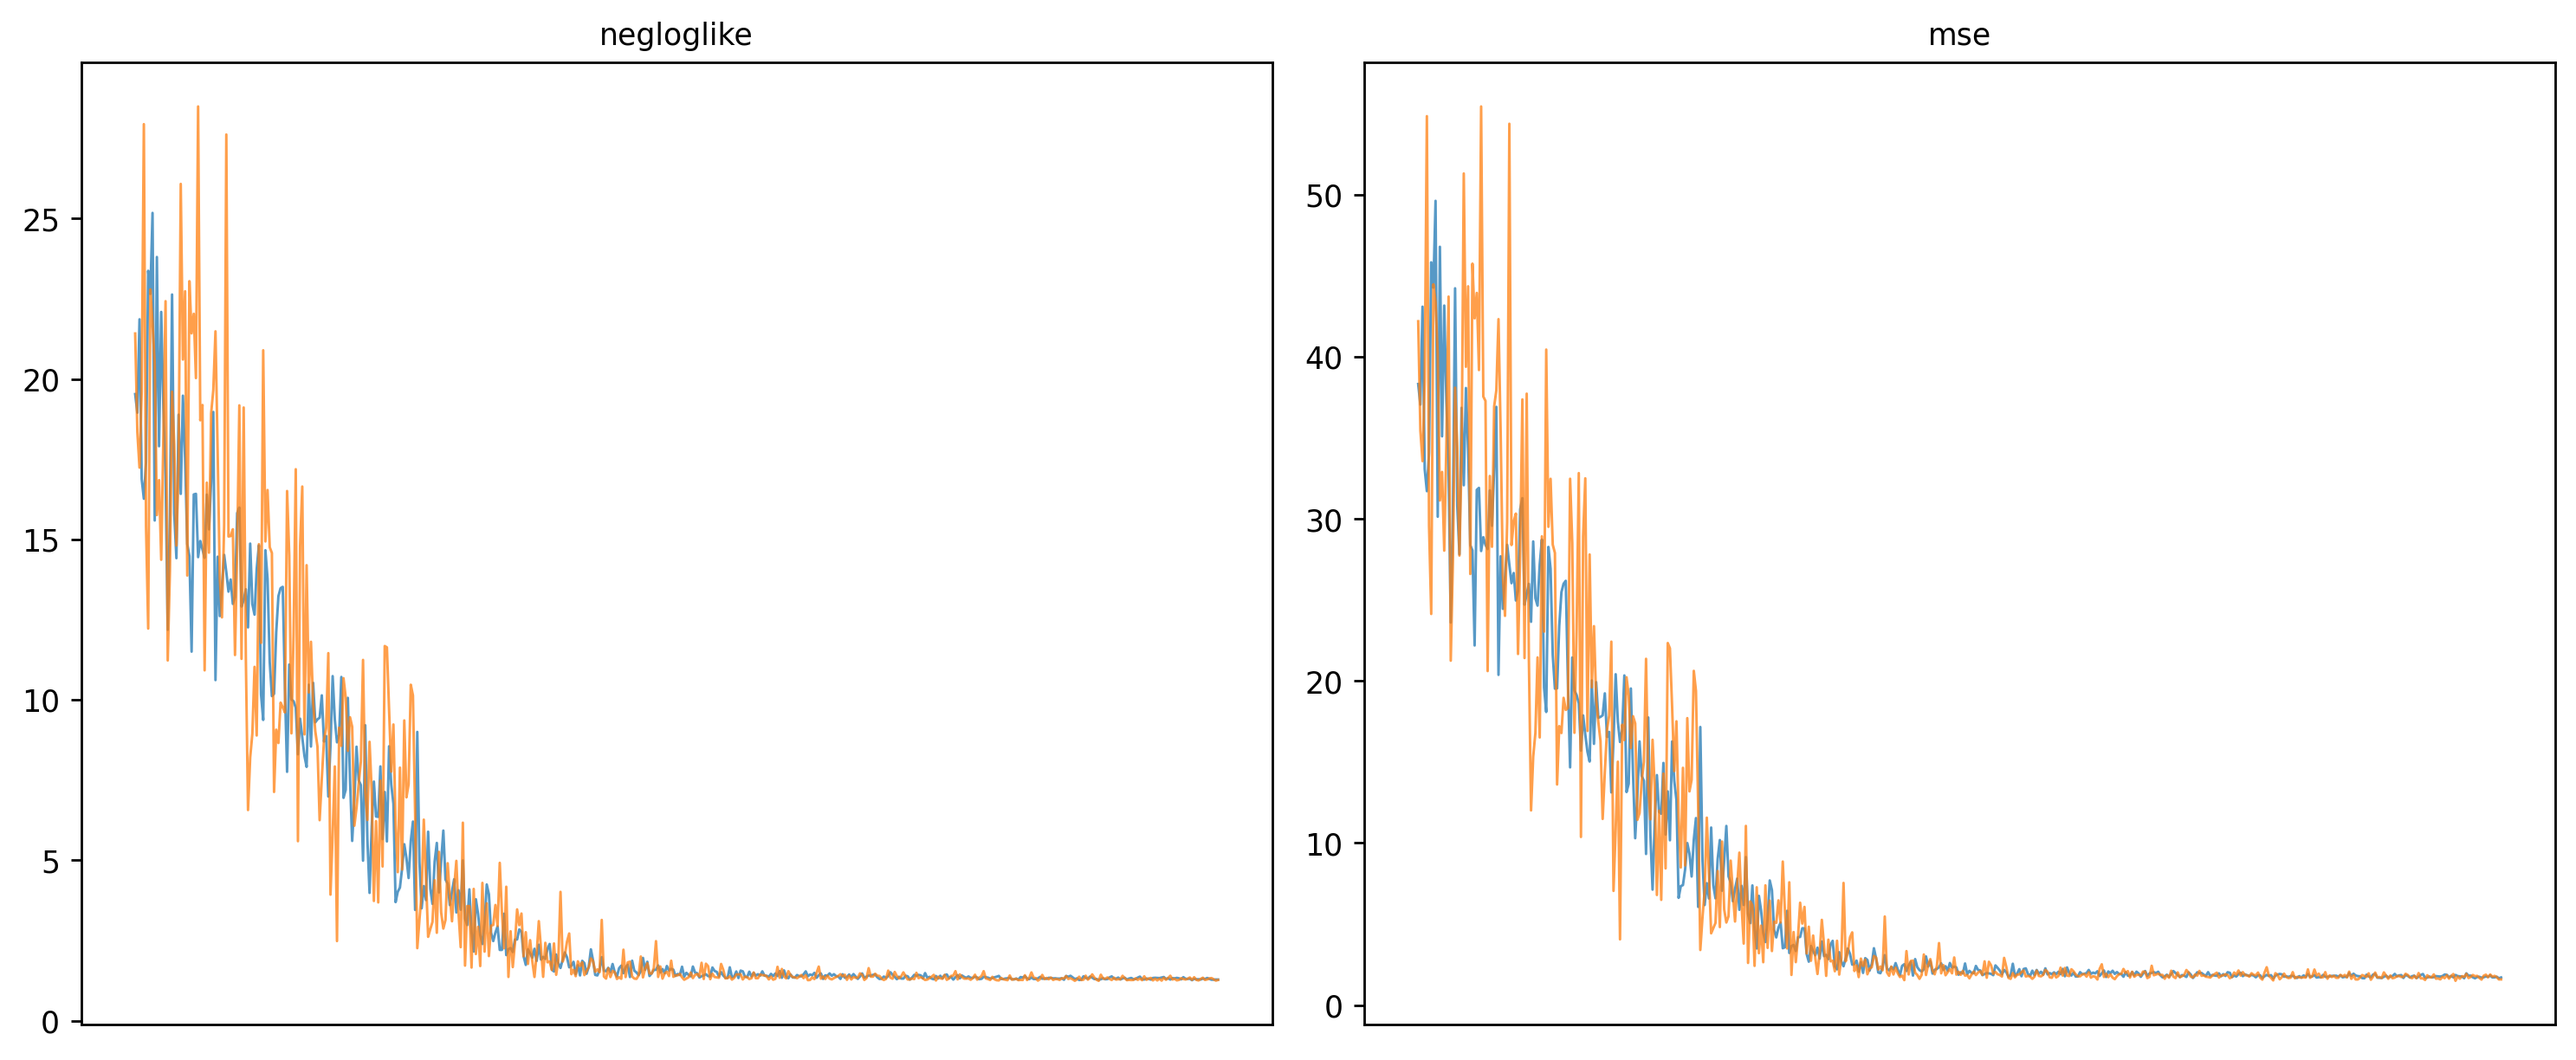

In [ ]:
funs.metrics_plotter(history, ['loss','mse'], loss="negloglike")

#### Option 3

Output is a Normal Distribution with Learnable Means and Deviations

$$ \mathbf{\hat{y}} \sim \mathrm{N} \left( \mu_{\mathbf{x}}, \: \sigma^{2}_{\mathbf{x}} \right)$$

$$ \mu_x = \mathbb{E} \left [ \mathbf{\hat{y}} \mid \mathbf{x},\mathbf{w} \right ] = \mathbf{xw}$$

In [ ]:
model = keras.models.Sequential([
    tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid'),
    tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid'),
    tfp.layers.DenseVariational(2, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
])

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['mse'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
funs.metrics_printer(metrics, machine='regressor', p=True)

TEST METRICS
negloglike 	 1.23 
MSE 		 1.40


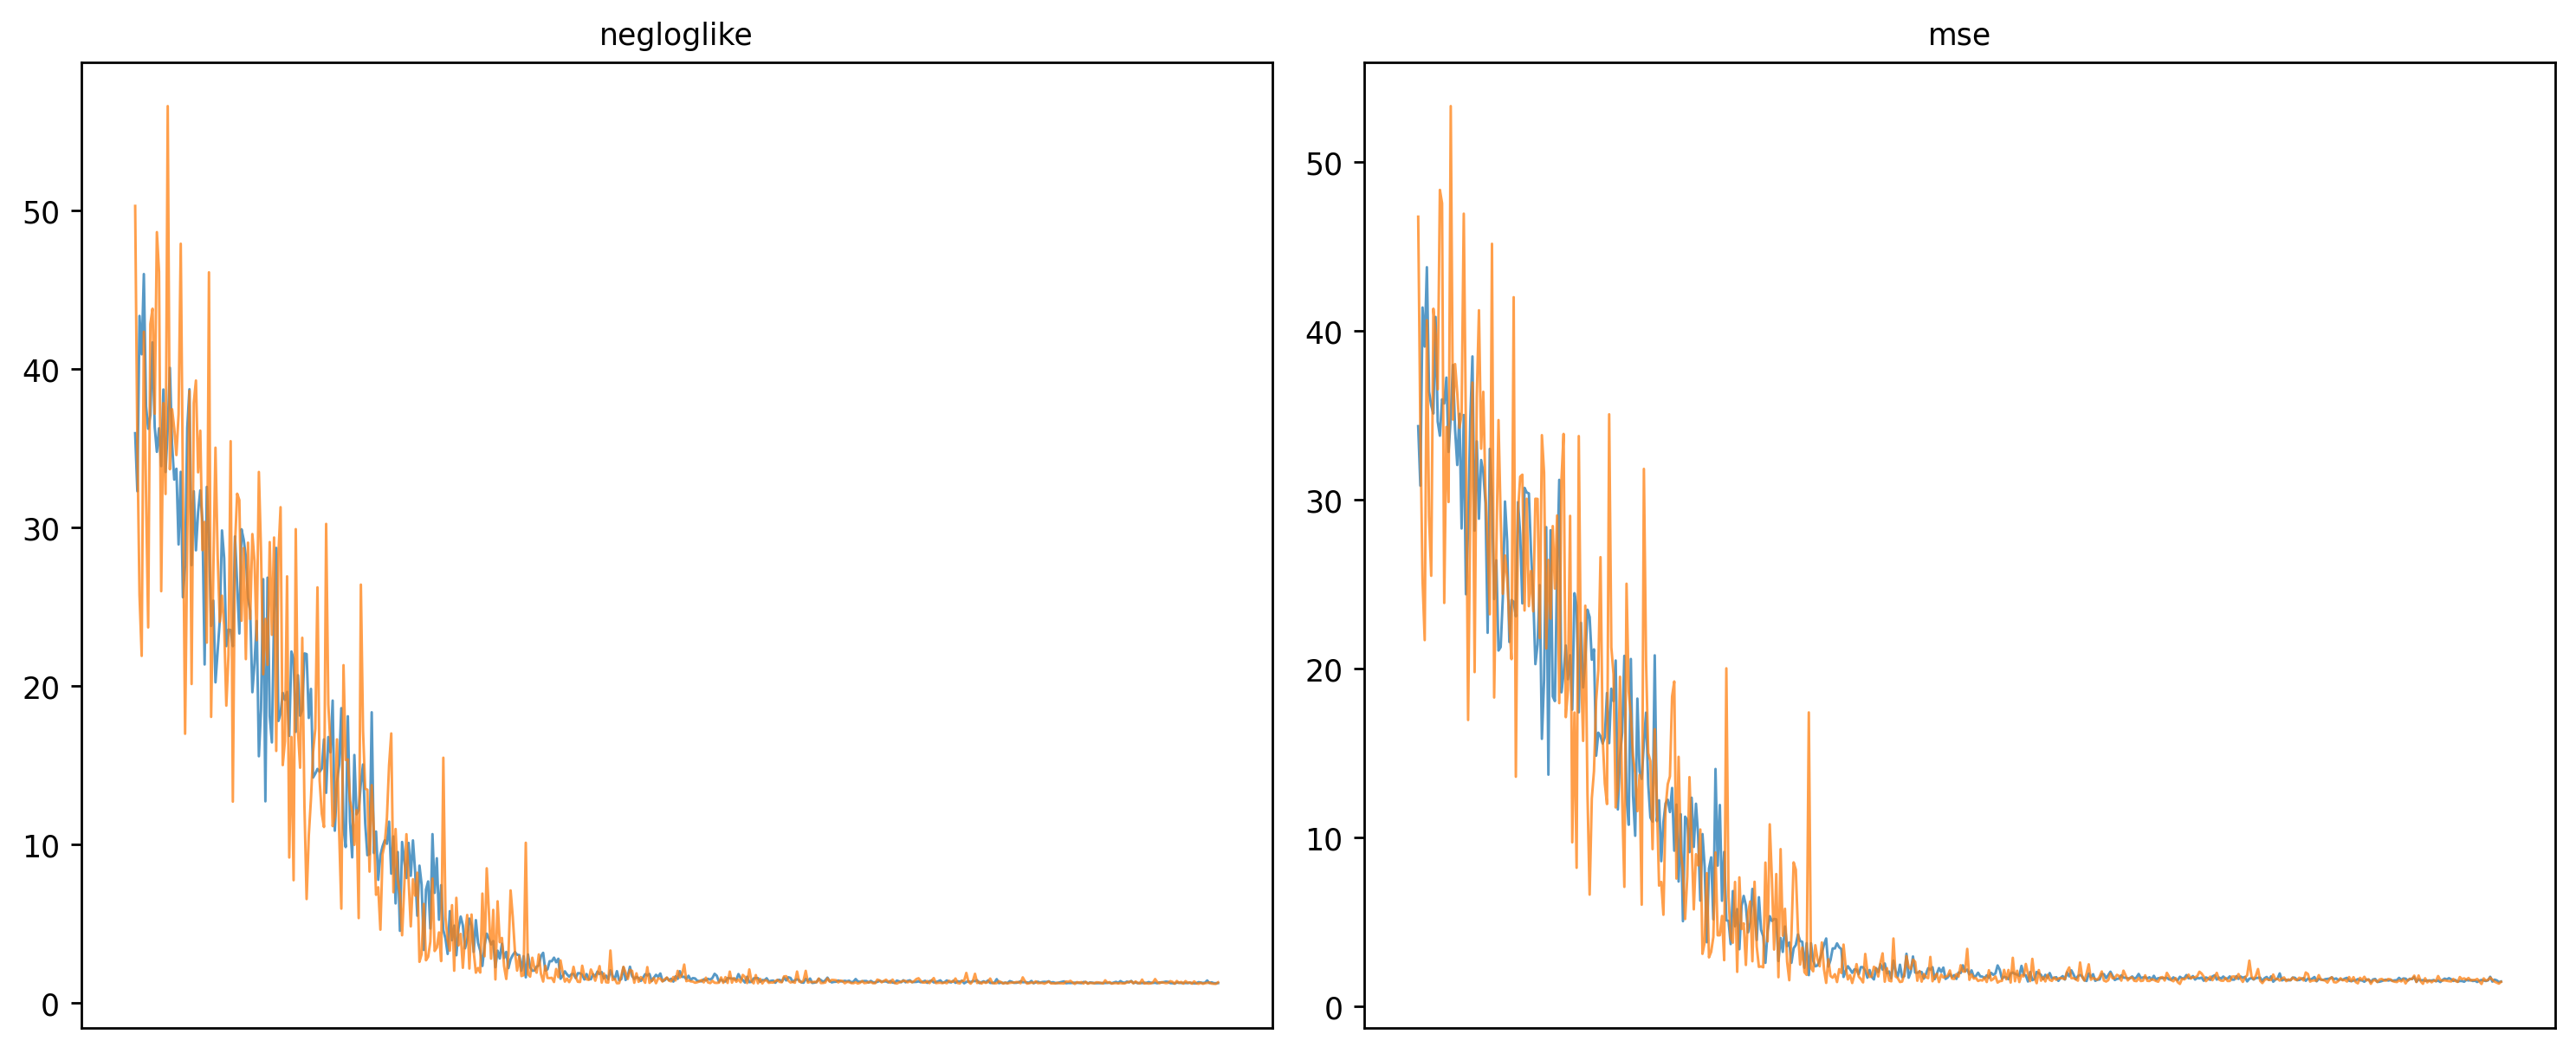

In [ ]:
funs.metrics_plotter(history, ['loss','mse'], loss="negloglike")

### 4. Known and Unkown Unkowns: The *Aleatoric* & *Epistemic* Uncertainty 

Bayesian Neural Network with trainable mean and variances – weight have a posterior distribution.

<br>

$$ \mathbf{\hat{y}} \sim \mathrm{N} \left( \mu, \: \sigma^{2}_{n} \right)$$

$$ \mu = \mathbb{E} \left [ \mathbf{\hat{y}} \mid \mathbf{X},\mathbf{w} \right ] = \mathbf{Xw}$$

<br>


In [ ]:
# Build the neural network regressor in sequential form.
# A probabilistic output is created with a normal distribution.
# The dense layer with two units is set to learn the mean and deviation of the destribution.

model = keras.models.Sequential([
    tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid'),
    tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid'),
    tf.keras.layers.Dense(2),
    tfp.layers.IndependentNormal(1)
])

# Compile the model using the values from params for optimizer, lr, loss, and a metric if stated.
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['mse'])
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metrics = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
funs.metrics_printer(metrics, machine='regressor', p=True)

TEST METRICS
negloglike 	 1.16 
MSE 		 1.21


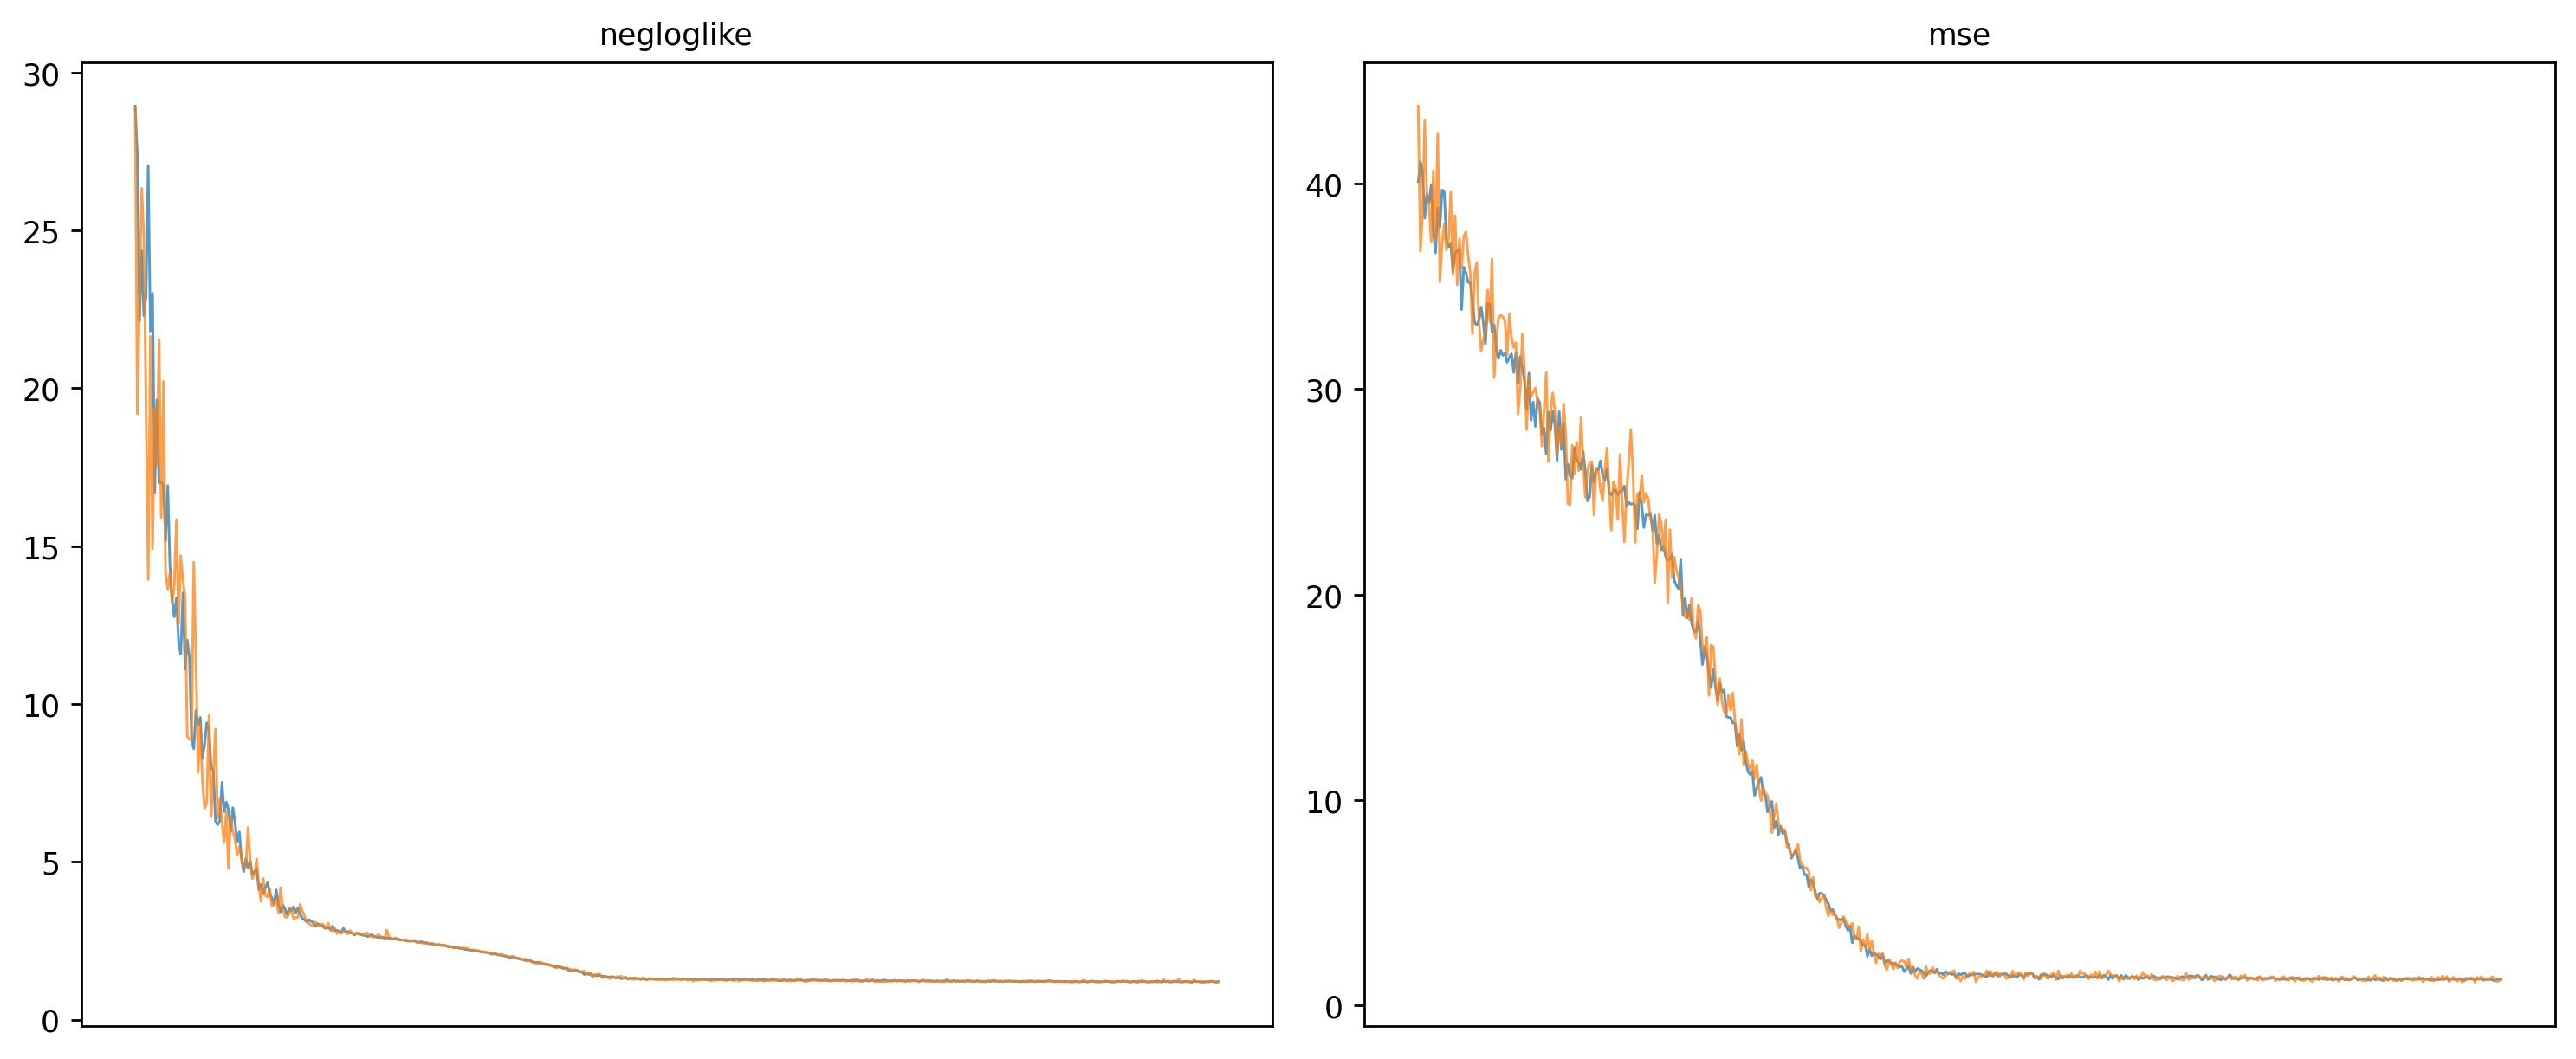

In [ ]:
funs.metrics_plotter(history, ['loss','mse'], loss="negloglike")

In [ ]:
# Functional coding of Bayesian neural network.
inputs = tf.keras.Input(shape=(X_train.shape[1], ))
layers = tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid')(inputs)
layers = tfp.layers.DenseVariational(4, make_prior_fn=prior_fn, make_posterior_fn=posterior_fn, kl_weight=kl_weight, activation='sigmoid')(layers)
params = keras.layers.Dense(2)(layers)
dist = tfp.layers.IndependentNormal(1)(params)

parameters = keras.models.Model(inputs=inputs, outputs=params)
distributions = keras.models.Model(inputs=inputs, outputs=dist)

distributions.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=negloglike, metrics=['mse'])
history = distributions.fit(X_train, y_train, epochs=500, validation_data=(X_valid, y_valid), batch_size=512, verbose=0)
metric = distributions.evaluate(X_test, y_test, verbose=0)

In [ ]:
funs.metrics_printer(metrics, machine='regressor', p=True)

TEST METRICS
negloglike 	 1.16 
MSE 		 1.21


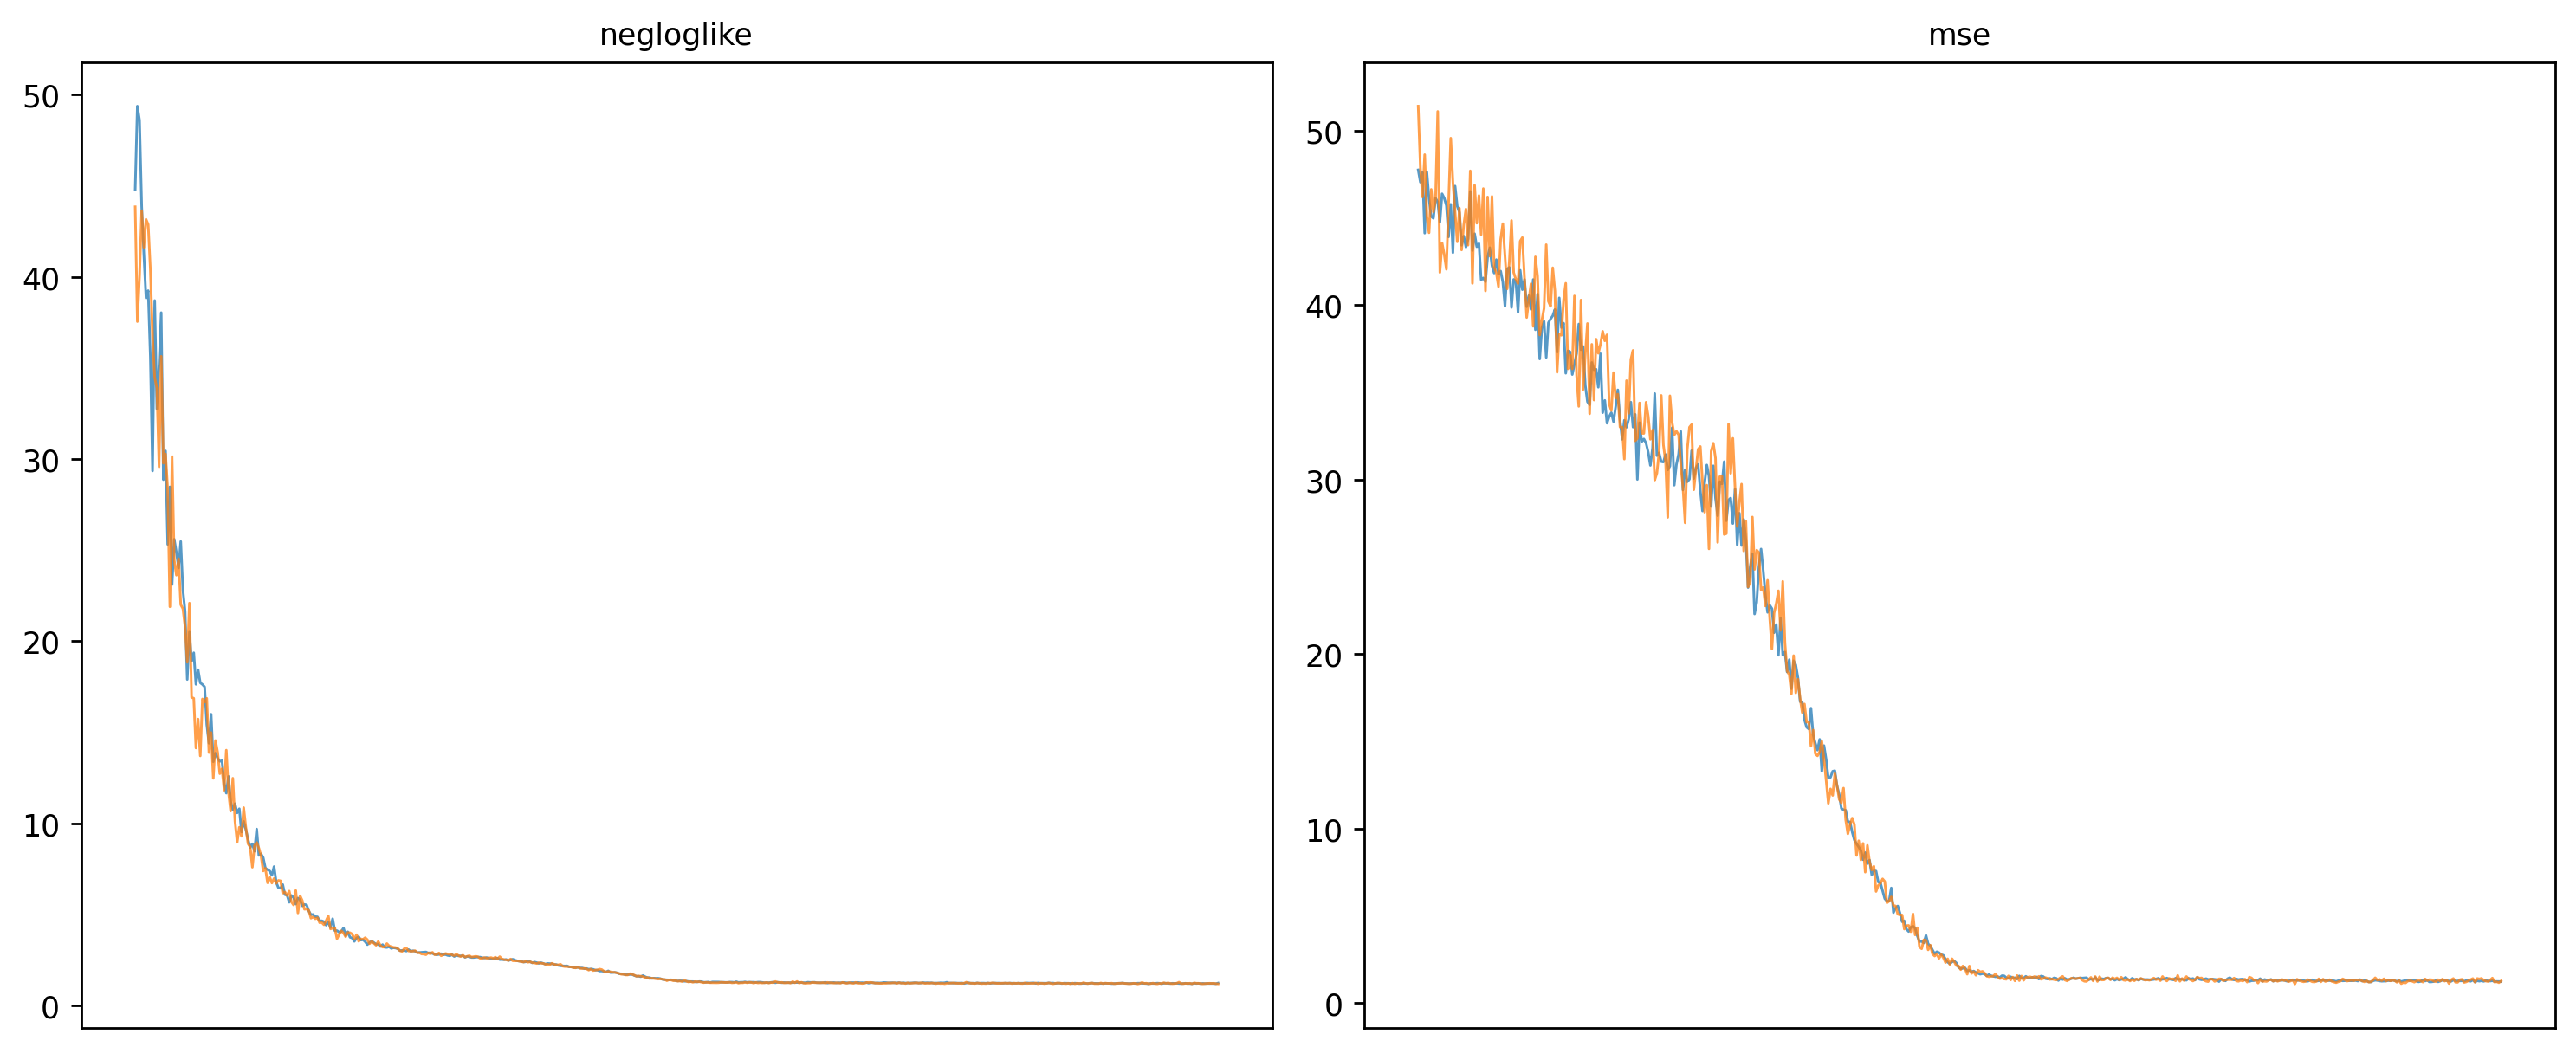

In [ ]:
funs.metrics_plotter(history, ['loss','mse'], loss="negloglike")

Analysis

In [348]:
seq_mean = []; seq_stddev = []
fun_mean = []; fun_stddev = []
par_mean = []; par_stddev = []

test = X_test[0].reshape(1,14)
real = y_test.iloc[0]

for i in range(0,1000):
    seq_mean.append(np.squeeze(model(test).mean()).item())
    seq_stddev.append(np.squeeze(model(test).stddev()).item())

    fun_mean.append(np.squeeze(functional(test).mean()).item())
    fun_stddev.append(np.squeeze(functional(test).stddev()).item())

    mean, std = np.squeeze(parameters.predict(test, verbose=0))[0], np.squeeze(parameters.predict(test, verbose=0))[1]
    par_mean.append(mean)
    par_stddev.append(std)

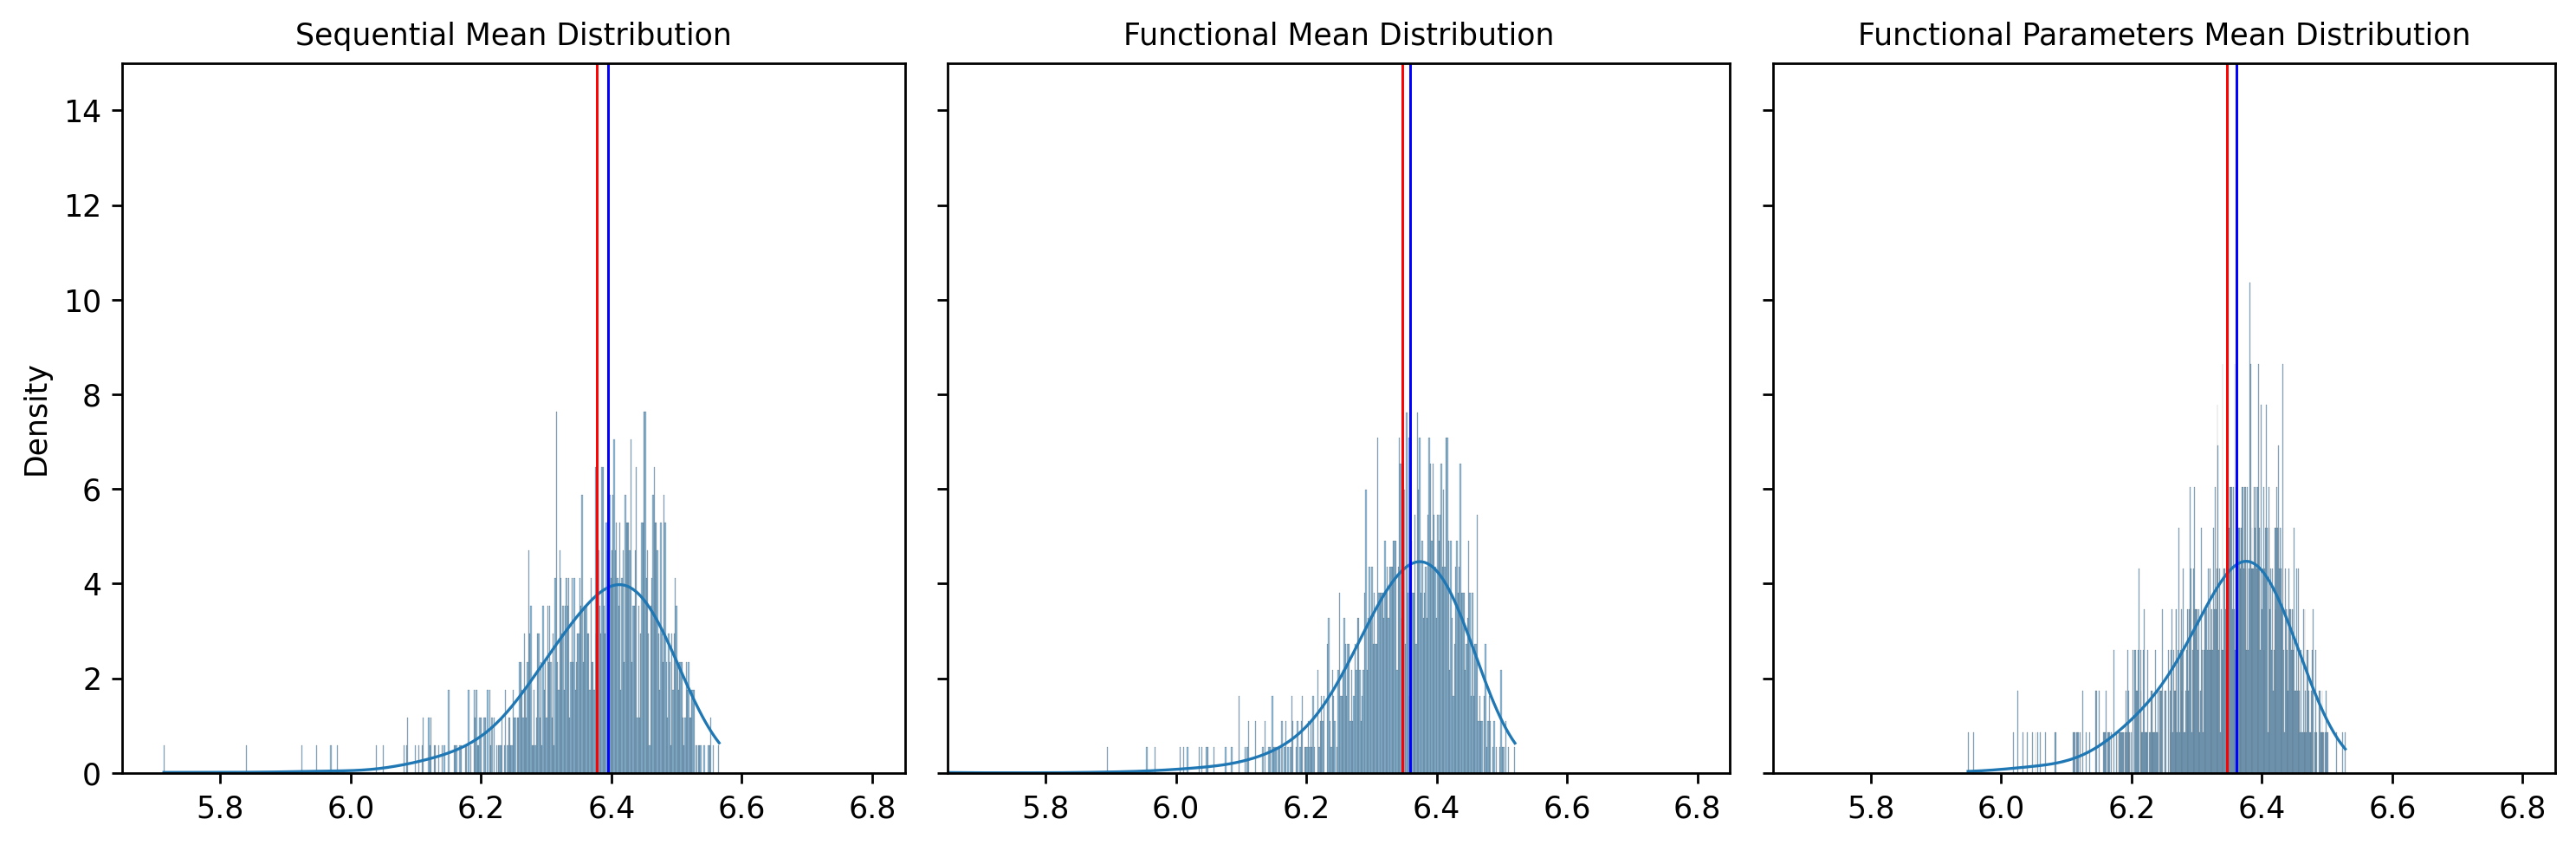

In [443]:
plt_params(250, 12, 4)
fig, ax = plt.subplots(1, 3, sharey=True)

titles = ['Sequential Mean Distribution', 'Functional Mean Distribution', 'Functional Parameters Mean Distribution']

for i, x in enumerate([seq_mean, fun_mean, par_mean]):
    
    sns.histplot(x=x, bins=500, stat='density', kde=True, kde_kws={'bw_method':0.5}, line_kws={'lw':0.95}, ax=ax[i])
    ax[i].axvline(x=np.median(x), color='blue', lw=0.85, ls='-')
    ax[i].axvline(x=np.mean(x), color='red', lw=0.85, ls='-')
    ax[i].set_title(titles[i], fontsize=10)

# Setting the values for all axes.
plt.setp(ax, xlim=(5.65,6.85), ylim=(0,15))

plt.tight_layout()
plt.show()

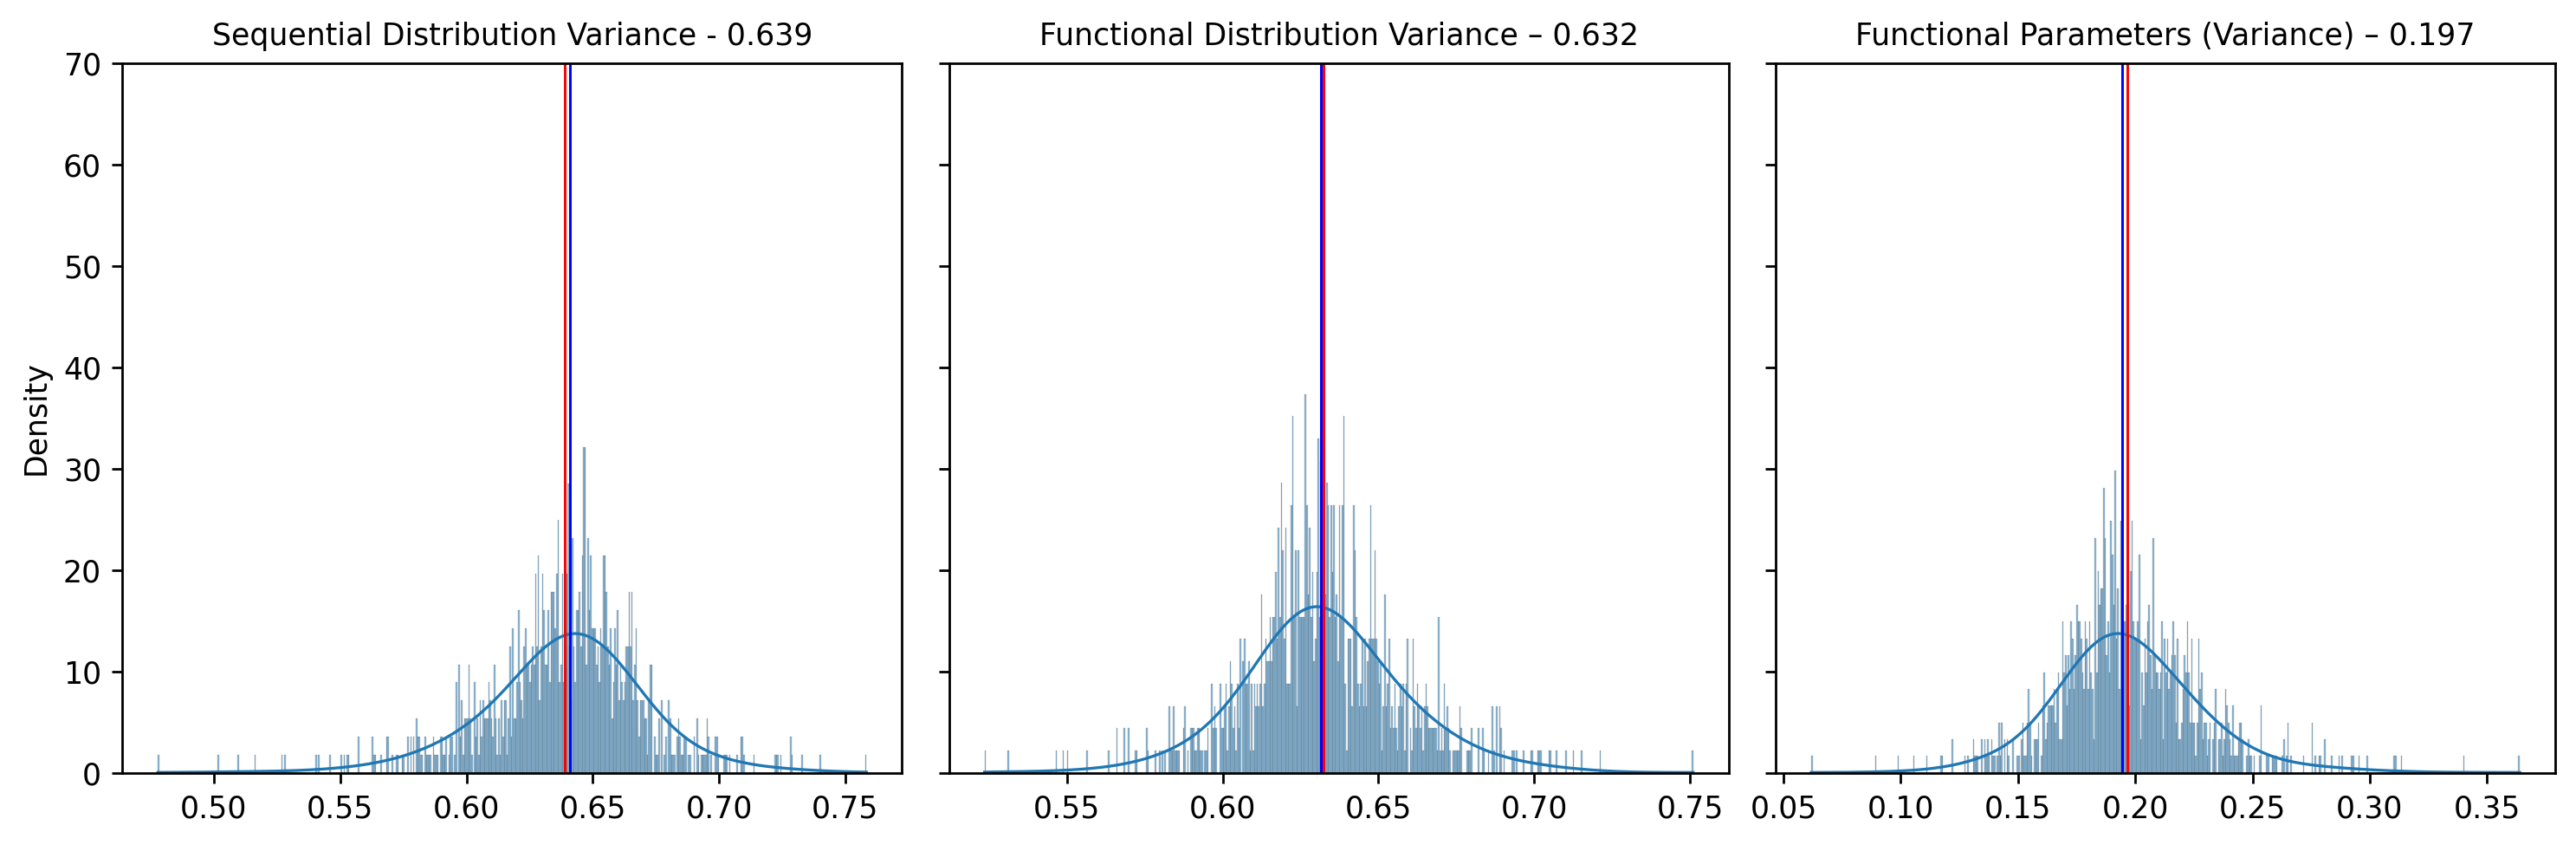

In [359]:
fig, ax = plt.subplots(1, 3, sharey=True)

titles = ['Sequential Distribution Variance - ', 'Functional Distribution Variance – ', 'Functional Parameters (Variance) – ']

for i, x in enumerate([np.array(seq_stddev) ** 2, np.array(fun_stddev) ** 2, np.array(par_stddev)]):
    sns.histplot(x=x, bins=500, stat='density', kde=True, kde_kws={'bw_method':0.5}, line_kws={'lw':0.95}, ax=ax[i])
    ax[i].axvline(x=np.median(x), color='blue', lw=0.85, ls='-')
    ax[i].axvline(x=np.mean(x), color='red', lw=0.85, ls='-')
    ax[i].set_title(titles[i] + str(np.round(np.mean(x), 3)), fontsize=10)

# Setting the values for all axes.
plt.setp(ax, ylim=(0,70))

plt.tight_layout()
plt.show()

In [448]:
seq_sample = []; seq_predict = [] 
fun_sample = []; fun_predict = []

for i in range(0,1000):
    seq_sample.append(model(test).sample().numpy().item())
    fun_sample.append(functional(test).sample().numpy().item())

    seq_predict.append(model.predict(test, verbose=0).item())
    fun_predict.append(functional.predict(test, verbose=0).item())


In [449]:
real = y_test.iloc[0]

In [450]:
def sample_plotter(list, real):

    fig, ax = plt.subplots(1, 2, sharey=True)

    titles = ['Sequential Prediction Distribution', 'Functional Prediction Distribution']

    for i, x in enumerate(list):

        mean = np.mean(x); var = np.var(x); std = np.std(x)
        
        sns.histplot(x=x, bins=500, stat='density', kde=True, edgecolor=None, kde_kws={'bw_method':0.5}, line_kws={'lw':0.95}, ax=ax[i])
        
        ax[i].text(x=mean + 0.25, y=1.15, s='Mean: ' + str(np.round(mean, 3)), fontsize=8)
        ax[i].text(x=mean + 0.25, y=1.10, s='Variance: ' + str(np.round(var, 3)), fontsize=8)
        ax[i].text(x=mean + 0.25, y=1.00, s='Real: ' + str(real), fontsize=8)
        ax[i].axvline(x=mean + 2 * std, color='k', lw=0.85, ls='--')
        ax[i].axvline(x=mean - 2 * std, color='k', lw=0.85, ls='--')
        ax[i].axvline(x=mean + 2 * std, color='k', lw=0.85, ls='dotted')
        ax[i].axvline(x=mean - 2 * std, color='k', lw=0.85, ls='dotted')
        ax[i].axvline(x=mean, color='k', lw=0.85, ls='-')
        ax[i].axvline(x=real, color='r', lw=0.85, ls='-')
        ax[i].set_title(titles[i], fontsize=10)

    # Setting the values for all axes.
    plt.setp(ax, xlim=(3.8,9.2), ylim=(0,1.25))

    plt.tight_layout()
    plt.show()

With Sampling

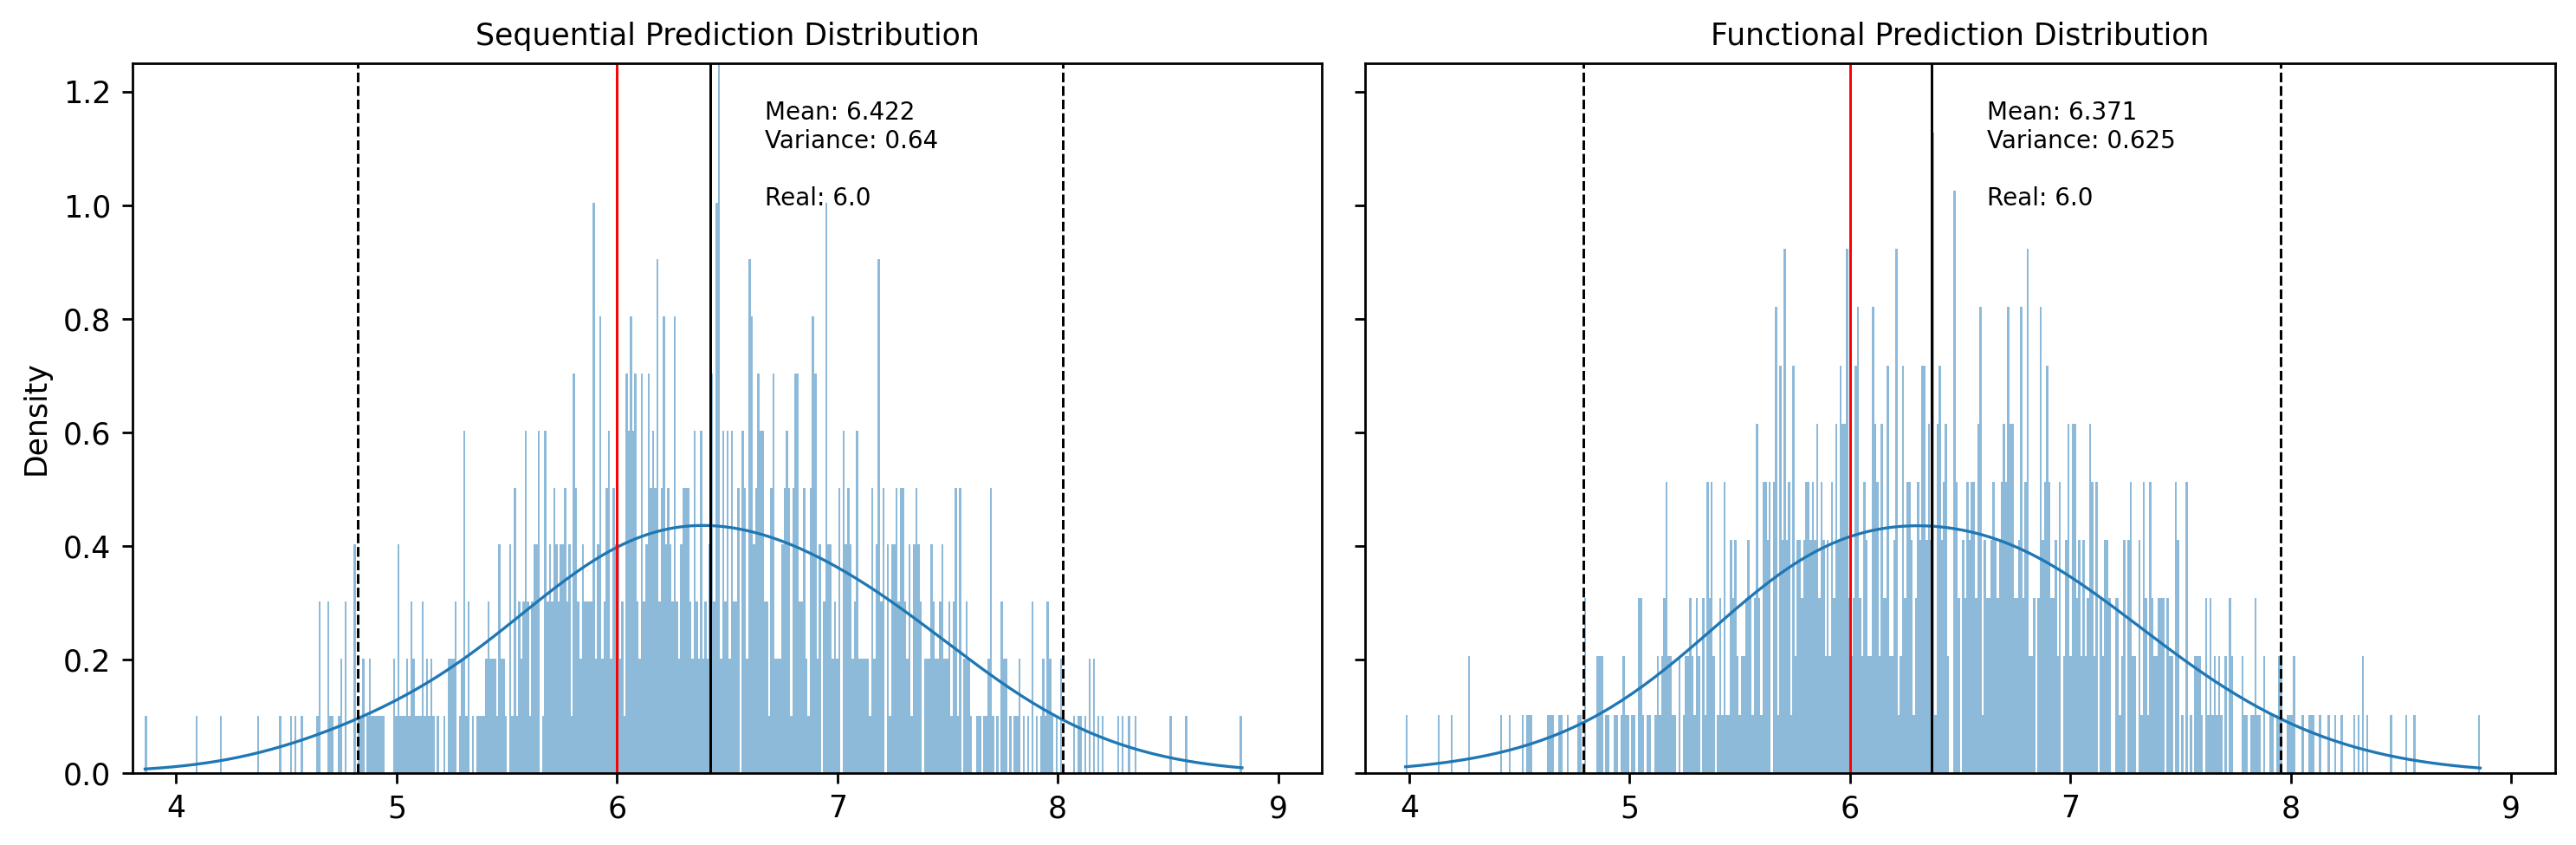

In [451]:
sample_plotter([seq_sample, fun_sample], real)

With Predict

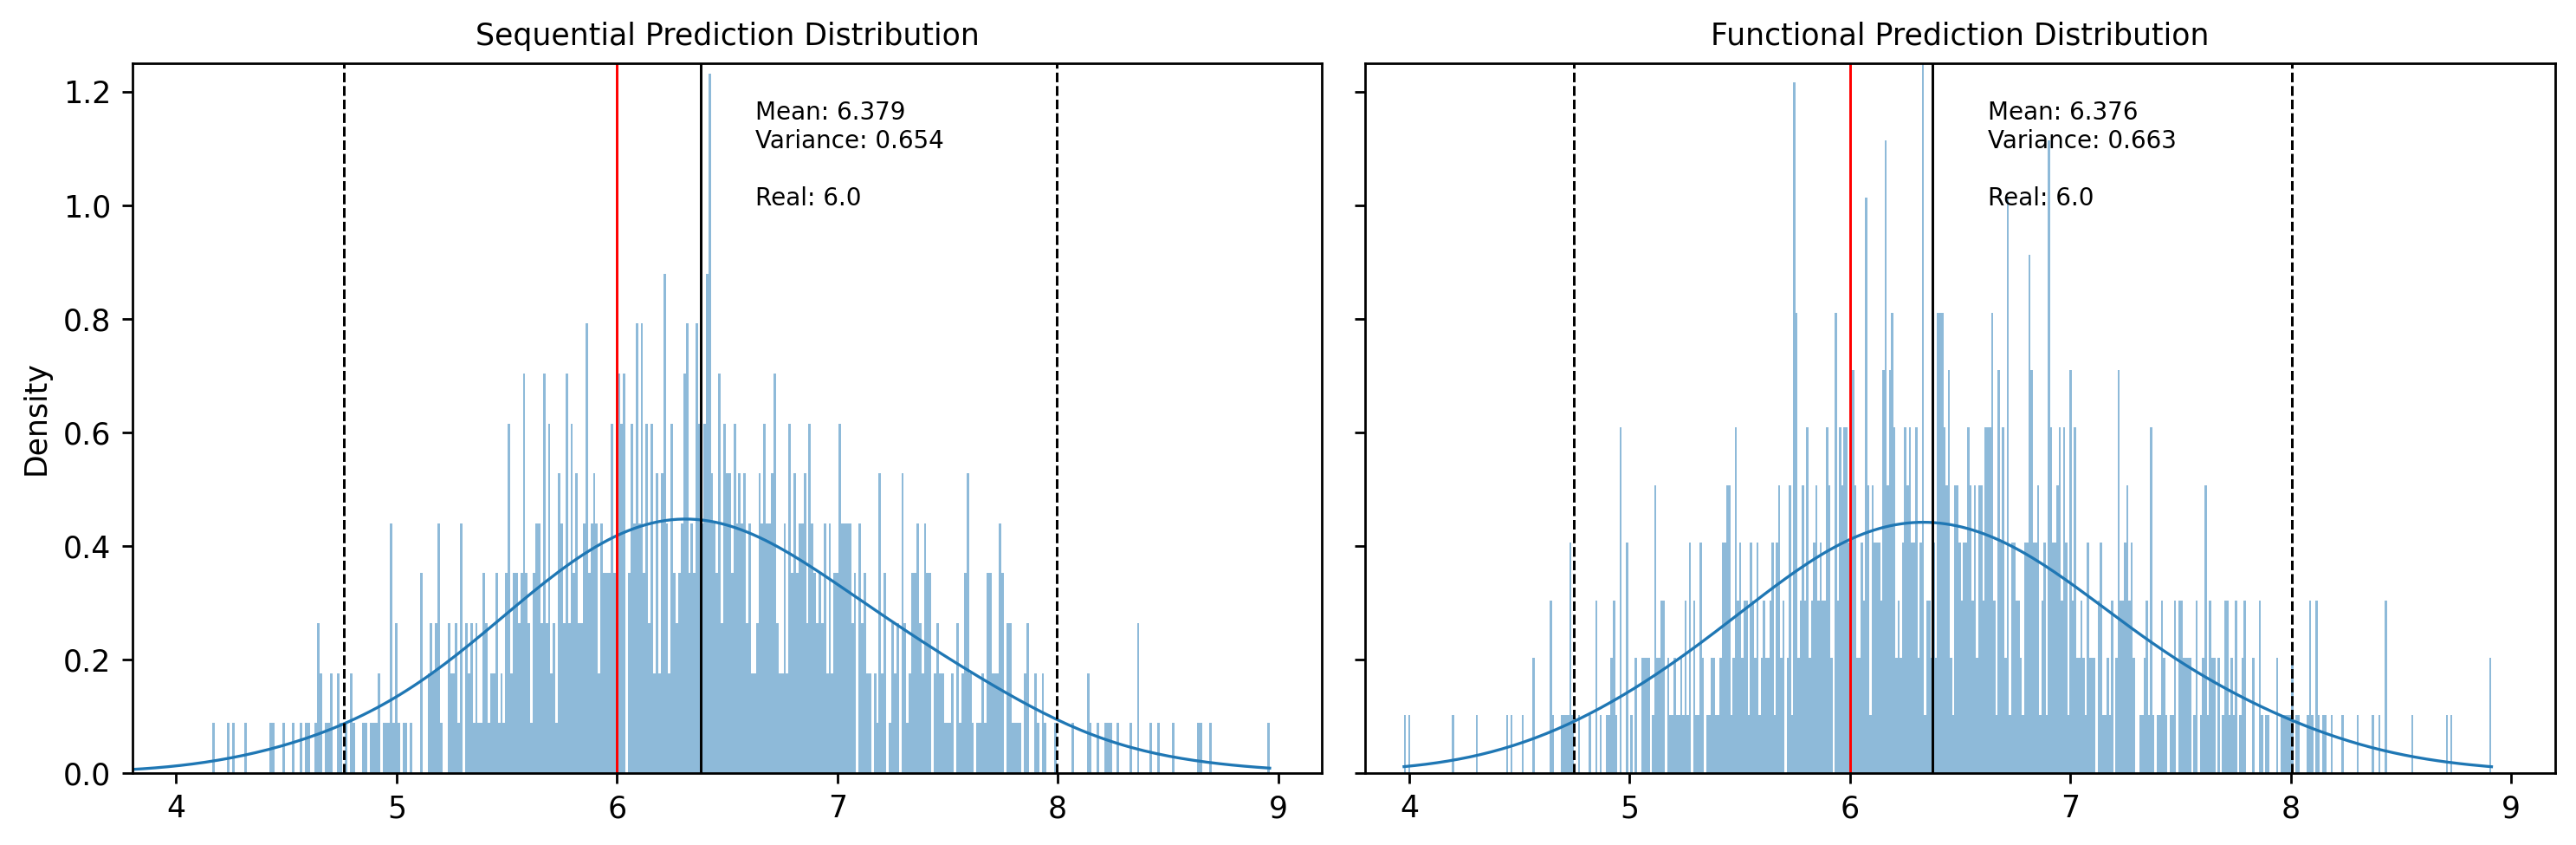

In [452]:
sample_plotter([seq_predict, fun_predict], real)